Most existing approaches to visual odometry are based on the following stages.

1. Acquire input images
2. Image correction: apply image processing techniques for lens distortion removal, etc.
3. Feature detection: define interest operators, and match features across frames and construct optical flow field.
       
4. Check flow field vectors for potential tracking errors and remove outliers.
5. Estimation of the camera motion from the optical flow.
       
6. Periodic repopulation of trackpoints to maintain coverage across the image.

Gathering the input images from the locally saved KITTI dataset. 

In [1]:
################################KITTI Dataset################################
#adapted from https://github.com/uoip/monoVO-python 
%run pinhole_camera.py

##kitti setup
poses_dir = 'dataset/poses/00.txt' #for ground truth
img_dir = 'dataset/sequences/00/image_0/'
cam = PinholeCamera(1241.0, 376.0, 718.8560, 718.8560, 607.1928, 185.2157)
with open(poses_dir) as f: poses = f.readlines()#poses
print "kitti loaded."

kitti loaded.


Performing the visual odometry

In [48]:
################################Visual Odometry################################

vo = VisualOdometry(cam, poses_dir)

traj = np.zeros((600,600,3), dtype=np.uint8)

predicted, actual = [],[]
# predicted = np.array(predicted)
# actual = np.array(actual)

frames_arr= []
import time
start = time.time()
frames = 1000
#drawing trajectories for each frame starting form the 3rd
for img_id in range(frames):
    img = cv2.imread(img_dir+str(img_id).zfill(6)+'.png', 0)
    
    vo.update(img, img_id)

    cur_t = vo.cur_t
    
    if(img_id > 2): 
        x, y, z = cur_t[0], cur_t[1], cur_t[2]
    else: 
        x, y, z = 0., 0., 0.
        
    #offset so the 2 trajectories do not overlap
    x_offset, y_offset = 0, 0
    draw_x, draw_y = int(x)+(290-x_offset), int(z)+(90-y_offset)
    true_x, true_y = int(vo.trueX)+290, int(vo.trueZ)+90
    
    #for drawing error line
    predicted.append((x,y))
    actual.append((vo.trueX, vo.trueY))
    
    
    #openCV uses BGR colour schemes as tuples, e.g (255,0,0) is blue
    #predicted trajectory in 
    cv2.circle(traj, (draw_x,draw_y), 1, (0,255,0), 1)
    #actual trajectory
    cv2.circle(traj, (true_x,true_y), 1, (0,0,255), 1)
    cv2.rectangle(traj, (10, 20), (600, 60), (0,0,0), -1)
    
    #disaplying the current coordinates in the window     
    text = "Coordinates: x=%2fm y=%2fm z=%2fm"%(x,y,z)
    cv2.putText(traj, text, (20,40), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8)
    #disaplying the current frame in the window     
    frame = "Frame: " + str(img_id) + " FPS: " + str(curr_fps)
    cv2.putText(traj, frame, (20,60), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8)
    cv2.rectangle(traj, (10, 40), (600, 60), (0,0,0), -1)    
    
    sec = time.time()
    curr_secs = sec - start
    curr_fps = img_id/curr_secs
    frames_arr.append(curr_fps)
    
    #disaplying the current fps in the window     
    fps = "FPS: " + str(curr_fps)
    cv2.putText(traj, frame, (30,60), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8)
    
    cv2.imshow('Road facing camera', img)
    cv2.imshow('Trajectory', traj)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

# cv2.imwrite('map.png', traj)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

This part of the code deals with testing the performance in terms of frames per second(FPS) for 20 iterations and a random amount of frames from a range between 200 and 2000.

All the image visualisation has been removed.

In [75]:
import numpy as np
import random
import time

vo = VisualOdometry(cam, poses_dir)

total_fps = []
iterations=20
frame_range=(200,2000)

print "Starting the 20 iterations"
for i in range(iterations):
    frames = random.randint(200,2000)    
    start = time.time()
    frames_arr= []
    #reading the images and performing VO
    for img_id in range(frames):
        img = cv2.imread(img_dir+str(img_id).zfill(6)+'.png', 0)
        vo.update(img, img_id)
        print "Frame "+str(img_id)+"/"+str(frames)+" from iteration "+str(i)+" was proccessed."
    #calculating the FPS
    end = time.time()
    seconds = end - start
    fps = frames/seconds
    total_fps.append((frames,fps))
    
print (np.array(total_fps)).reshape(20,2)

Starting the 20 iterations
Frame 0/1218 from iteration 0 was proccessed.
Frame 1/1218 from iteration 0 was proccessed.
Frame 2/1218 from iteration 0 was proccessed.
Frame 3/1218 from iteration 0 was proccessed.
Frame 4/1218 from iteration 0 was proccessed.
Frame 5/1218 from iteration 0 was proccessed.
Frame 6/1218 from iteration 0 was proccessed.
Frame 7/1218 from iteration 0 was proccessed.
Frame 8/1218 from iteration 0 was proccessed.
Frame 9/1218 from iteration 0 was proccessed.
Frame 10/1218 from iteration 0 was proccessed.
Frame 11/1218 from iteration 0 was proccessed.
Frame 12/1218 from iteration 0 was proccessed.
Frame 13/1218 from iteration 0 was proccessed.
Frame 14/1218 from iteration 0 was proccessed.
Frame 15/1218 from iteration 0 was proccessed.
Frame 16/1218 from iteration 0 was proccessed.
Frame 17/1218 from iteration 0 was proccessed.
Frame 18/1218 from iteration 0 was proccessed.
Frame 19/1218 from iteration 0 was proccessed.
Frame 20/1218 from iteration 0 was proccess

Frame 173/1218 from iteration 0 was proccessed.
Frame 174/1218 from iteration 0 was proccessed.
Frame 175/1218 from iteration 0 was proccessed.
Frame 176/1218 from iteration 0 was proccessed.
Frame 177/1218 from iteration 0 was proccessed.
Frame 178/1218 from iteration 0 was proccessed.
Frame 179/1218 from iteration 0 was proccessed.
Frame 180/1218 from iteration 0 was proccessed.
Frame 181/1218 from iteration 0 was proccessed.
Frame 182/1218 from iteration 0 was proccessed.
Frame 183/1218 from iteration 0 was proccessed.
Frame 184/1218 from iteration 0 was proccessed.
Frame 185/1218 from iteration 0 was proccessed.
Frame 186/1218 from iteration 0 was proccessed.
Frame 187/1218 from iteration 0 was proccessed.
Frame 188/1218 from iteration 0 was proccessed.
Frame 189/1218 from iteration 0 was proccessed.
Frame 190/1218 from iteration 0 was proccessed.
Frame 191/1218 from iteration 0 was proccessed.
Frame 192/1218 from iteration 0 was proccessed.
Frame 193/1218 from iteration 0 was proc

Frame 346/1218 from iteration 0 was proccessed.
Frame 347/1218 from iteration 0 was proccessed.
Frame 348/1218 from iteration 0 was proccessed.
Frame 349/1218 from iteration 0 was proccessed.
Frame 350/1218 from iteration 0 was proccessed.
Frame 351/1218 from iteration 0 was proccessed.
Frame 352/1218 from iteration 0 was proccessed.
Frame 353/1218 from iteration 0 was proccessed.
Frame 354/1218 from iteration 0 was proccessed.
Frame 355/1218 from iteration 0 was proccessed.
Frame 356/1218 from iteration 0 was proccessed.
Frame 357/1218 from iteration 0 was proccessed.
Frame 358/1218 from iteration 0 was proccessed.
Frame 359/1218 from iteration 0 was proccessed.
Frame 360/1218 from iteration 0 was proccessed.
Frame 361/1218 from iteration 0 was proccessed.
Frame 362/1218 from iteration 0 was proccessed.
Frame 363/1218 from iteration 0 was proccessed.
Frame 364/1218 from iteration 0 was proccessed.
Frame 365/1218 from iteration 0 was proccessed.
Frame 366/1218 from iteration 0 was proc

Frame 517/1218 from iteration 0 was proccessed.
Frame 518/1218 from iteration 0 was proccessed.
Frame 519/1218 from iteration 0 was proccessed.
Frame 520/1218 from iteration 0 was proccessed.
Frame 521/1218 from iteration 0 was proccessed.
Frame 522/1218 from iteration 0 was proccessed.
Frame 523/1218 from iteration 0 was proccessed.
Frame 524/1218 from iteration 0 was proccessed.
Frame 525/1218 from iteration 0 was proccessed.
Frame 526/1218 from iteration 0 was proccessed.
Frame 527/1218 from iteration 0 was proccessed.
Frame 528/1218 from iteration 0 was proccessed.
Frame 529/1218 from iteration 0 was proccessed.
Frame 530/1218 from iteration 0 was proccessed.
Frame 531/1218 from iteration 0 was proccessed.
Frame 532/1218 from iteration 0 was proccessed.
Frame 533/1218 from iteration 0 was proccessed.
Frame 534/1218 from iteration 0 was proccessed.
Frame 535/1218 from iteration 0 was proccessed.
Frame 536/1218 from iteration 0 was proccessed.
Frame 537/1218 from iteration 0 was proc

Frame 688/1218 from iteration 0 was proccessed.
Frame 689/1218 from iteration 0 was proccessed.
Frame 690/1218 from iteration 0 was proccessed.
Frame 691/1218 from iteration 0 was proccessed.
Frame 692/1218 from iteration 0 was proccessed.
Frame 693/1218 from iteration 0 was proccessed.
Frame 694/1218 from iteration 0 was proccessed.
Frame 695/1218 from iteration 0 was proccessed.
Frame 696/1218 from iteration 0 was proccessed.
Frame 697/1218 from iteration 0 was proccessed.
Frame 698/1218 from iteration 0 was proccessed.
Frame 699/1218 from iteration 0 was proccessed.
Frame 700/1218 from iteration 0 was proccessed.
Frame 701/1218 from iteration 0 was proccessed.
Frame 702/1218 from iteration 0 was proccessed.
Frame 703/1218 from iteration 0 was proccessed.
Frame 704/1218 from iteration 0 was proccessed.
Frame 705/1218 from iteration 0 was proccessed.
Frame 706/1218 from iteration 0 was proccessed.
Frame 707/1218 from iteration 0 was proccessed.
Frame 708/1218 from iteration 0 was proc

Frame 860/1218 from iteration 0 was proccessed.
Frame 861/1218 from iteration 0 was proccessed.
Frame 862/1218 from iteration 0 was proccessed.
Frame 863/1218 from iteration 0 was proccessed.
Frame 864/1218 from iteration 0 was proccessed.
Frame 865/1218 from iteration 0 was proccessed.
Frame 866/1218 from iteration 0 was proccessed.
Frame 867/1218 from iteration 0 was proccessed.
Frame 868/1218 from iteration 0 was proccessed.
Frame 869/1218 from iteration 0 was proccessed.
Frame 870/1218 from iteration 0 was proccessed.
Frame 871/1218 from iteration 0 was proccessed.
Frame 872/1218 from iteration 0 was proccessed.
Frame 873/1218 from iteration 0 was proccessed.
Frame 874/1218 from iteration 0 was proccessed.
Frame 875/1218 from iteration 0 was proccessed.
Frame 876/1218 from iteration 0 was proccessed.
Frame 877/1218 from iteration 0 was proccessed.
Frame 878/1218 from iteration 0 was proccessed.
Frame 879/1218 from iteration 0 was proccessed.
Frame 880/1218 from iteration 0 was proc

Frame 1033/1218 from iteration 0 was proccessed.
Frame 1034/1218 from iteration 0 was proccessed.
Frame 1035/1218 from iteration 0 was proccessed.
Frame 1036/1218 from iteration 0 was proccessed.
Frame 1037/1218 from iteration 0 was proccessed.
Frame 1038/1218 from iteration 0 was proccessed.
Frame 1039/1218 from iteration 0 was proccessed.
Frame 1040/1218 from iteration 0 was proccessed.
Frame 1041/1218 from iteration 0 was proccessed.
Frame 1042/1218 from iteration 0 was proccessed.
Frame 1043/1218 from iteration 0 was proccessed.
Frame 1044/1218 from iteration 0 was proccessed.
Frame 1045/1218 from iteration 0 was proccessed.
Frame 1046/1218 from iteration 0 was proccessed.
Frame 1047/1218 from iteration 0 was proccessed.
Frame 1048/1218 from iteration 0 was proccessed.
Frame 1049/1218 from iteration 0 was proccessed.
Frame 1050/1218 from iteration 0 was proccessed.
Frame 1051/1218 from iteration 0 was proccessed.
Frame 1052/1218 from iteration 0 was proccessed.
Frame 1053/1218 from

Frame 1202/1218 from iteration 0 was proccessed.
Frame 1203/1218 from iteration 0 was proccessed.
Frame 1204/1218 from iteration 0 was proccessed.
Frame 1205/1218 from iteration 0 was proccessed.
Frame 1206/1218 from iteration 0 was proccessed.
Frame 1207/1218 from iteration 0 was proccessed.
Frame 1208/1218 from iteration 0 was proccessed.
Frame 1209/1218 from iteration 0 was proccessed.
Frame 1210/1218 from iteration 0 was proccessed.
Frame 1211/1218 from iteration 0 was proccessed.
Frame 1212/1218 from iteration 0 was proccessed.
Frame 1213/1218 from iteration 0 was proccessed.
Frame 1214/1218 from iteration 0 was proccessed.
Frame 1215/1218 from iteration 0 was proccessed.
Frame 1216/1218 from iteration 0 was proccessed.
Frame 1217/1218 from iteration 0 was proccessed.
Frame 0/1730 from iteration 1 was proccessed.
Frame 1/1730 from iteration 1 was proccessed.
Frame 2/1730 from iteration 1 was proccessed.
Frame 3/1730 from iteration 1 was proccessed.
Frame 4/1730 from iteration 1 wa

Frame 159/1730 from iteration 1 was proccessed.
Frame 160/1730 from iteration 1 was proccessed.
Frame 161/1730 from iteration 1 was proccessed.
Frame 162/1730 from iteration 1 was proccessed.
Frame 163/1730 from iteration 1 was proccessed.
Frame 164/1730 from iteration 1 was proccessed.
Frame 165/1730 from iteration 1 was proccessed.
Frame 166/1730 from iteration 1 was proccessed.
Frame 167/1730 from iteration 1 was proccessed.
Frame 168/1730 from iteration 1 was proccessed.
Frame 169/1730 from iteration 1 was proccessed.
Frame 170/1730 from iteration 1 was proccessed.
Frame 171/1730 from iteration 1 was proccessed.
Frame 172/1730 from iteration 1 was proccessed.
Frame 173/1730 from iteration 1 was proccessed.
Frame 174/1730 from iteration 1 was proccessed.
Frame 175/1730 from iteration 1 was proccessed.
Frame 176/1730 from iteration 1 was proccessed.
Frame 177/1730 from iteration 1 was proccessed.
Frame 178/1730 from iteration 1 was proccessed.
Frame 179/1730 from iteration 1 was proc

Frame 333/1730 from iteration 1 was proccessed.
Frame 334/1730 from iteration 1 was proccessed.
Frame 335/1730 from iteration 1 was proccessed.
Frame 336/1730 from iteration 1 was proccessed.
Frame 337/1730 from iteration 1 was proccessed.
Frame 338/1730 from iteration 1 was proccessed.
Frame 339/1730 from iteration 1 was proccessed.
Frame 340/1730 from iteration 1 was proccessed.
Frame 341/1730 from iteration 1 was proccessed.
Frame 342/1730 from iteration 1 was proccessed.
Frame 343/1730 from iteration 1 was proccessed.
Frame 344/1730 from iteration 1 was proccessed.
Frame 345/1730 from iteration 1 was proccessed.
Frame 346/1730 from iteration 1 was proccessed.
Frame 347/1730 from iteration 1 was proccessed.
Frame 348/1730 from iteration 1 was proccessed.
Frame 349/1730 from iteration 1 was proccessed.
Frame 350/1730 from iteration 1 was proccessed.
Frame 351/1730 from iteration 1 was proccessed.
Frame 352/1730 from iteration 1 was proccessed.
Frame 353/1730 from iteration 1 was proc

Frame 504/1730 from iteration 1 was proccessed.
Frame 505/1730 from iteration 1 was proccessed.
Frame 506/1730 from iteration 1 was proccessed.
Frame 507/1730 from iteration 1 was proccessed.
Frame 508/1730 from iteration 1 was proccessed.
Frame 509/1730 from iteration 1 was proccessed.
Frame 510/1730 from iteration 1 was proccessed.
Frame 511/1730 from iteration 1 was proccessed.
Frame 512/1730 from iteration 1 was proccessed.
Frame 513/1730 from iteration 1 was proccessed.
Frame 514/1730 from iteration 1 was proccessed.
Frame 515/1730 from iteration 1 was proccessed.
Frame 516/1730 from iteration 1 was proccessed.
Frame 517/1730 from iteration 1 was proccessed.
Frame 518/1730 from iteration 1 was proccessed.
Frame 519/1730 from iteration 1 was proccessed.
Frame 520/1730 from iteration 1 was proccessed.
Frame 521/1730 from iteration 1 was proccessed.
Frame 522/1730 from iteration 1 was proccessed.
Frame 523/1730 from iteration 1 was proccessed.
Frame 524/1730 from iteration 1 was proc

Frame 675/1730 from iteration 1 was proccessed.
Frame 676/1730 from iteration 1 was proccessed.
Frame 677/1730 from iteration 1 was proccessed.
Frame 678/1730 from iteration 1 was proccessed.
Frame 679/1730 from iteration 1 was proccessed.
Frame 680/1730 from iteration 1 was proccessed.
Frame 681/1730 from iteration 1 was proccessed.
Frame 682/1730 from iteration 1 was proccessed.
Frame 683/1730 from iteration 1 was proccessed.
Frame 684/1730 from iteration 1 was proccessed.
Frame 685/1730 from iteration 1 was proccessed.
Frame 686/1730 from iteration 1 was proccessed.
Frame 687/1730 from iteration 1 was proccessed.
Frame 688/1730 from iteration 1 was proccessed.
Frame 689/1730 from iteration 1 was proccessed.
Frame 690/1730 from iteration 1 was proccessed.
Frame 691/1730 from iteration 1 was proccessed.
Frame 692/1730 from iteration 1 was proccessed.
Frame 693/1730 from iteration 1 was proccessed.
Frame 694/1730 from iteration 1 was proccessed.
Frame 695/1730 from iteration 1 was proc

Frame 848/1730 from iteration 1 was proccessed.
Frame 849/1730 from iteration 1 was proccessed.
Frame 850/1730 from iteration 1 was proccessed.
Frame 851/1730 from iteration 1 was proccessed.
Frame 852/1730 from iteration 1 was proccessed.
Frame 853/1730 from iteration 1 was proccessed.
Frame 854/1730 from iteration 1 was proccessed.
Frame 855/1730 from iteration 1 was proccessed.
Frame 856/1730 from iteration 1 was proccessed.
Frame 857/1730 from iteration 1 was proccessed.
Frame 858/1730 from iteration 1 was proccessed.
Frame 859/1730 from iteration 1 was proccessed.
Frame 860/1730 from iteration 1 was proccessed.
Frame 861/1730 from iteration 1 was proccessed.
Frame 862/1730 from iteration 1 was proccessed.
Frame 863/1730 from iteration 1 was proccessed.
Frame 864/1730 from iteration 1 was proccessed.
Frame 865/1730 from iteration 1 was proccessed.
Frame 866/1730 from iteration 1 was proccessed.
Frame 867/1730 from iteration 1 was proccessed.
Frame 868/1730 from iteration 1 was proc

Frame 1022/1730 from iteration 1 was proccessed.
Frame 1023/1730 from iteration 1 was proccessed.
Frame 1024/1730 from iteration 1 was proccessed.
Frame 1025/1730 from iteration 1 was proccessed.
Frame 1026/1730 from iteration 1 was proccessed.
Frame 1027/1730 from iteration 1 was proccessed.
Frame 1028/1730 from iteration 1 was proccessed.
Frame 1029/1730 from iteration 1 was proccessed.
Frame 1030/1730 from iteration 1 was proccessed.
Frame 1031/1730 from iteration 1 was proccessed.
Frame 1032/1730 from iteration 1 was proccessed.
Frame 1033/1730 from iteration 1 was proccessed.
Frame 1034/1730 from iteration 1 was proccessed.
Frame 1035/1730 from iteration 1 was proccessed.
Frame 1036/1730 from iteration 1 was proccessed.
Frame 1037/1730 from iteration 1 was proccessed.
Frame 1038/1730 from iteration 1 was proccessed.
Frame 1039/1730 from iteration 1 was proccessed.
Frame 1040/1730 from iteration 1 was proccessed.
Frame 1041/1730 from iteration 1 was proccessed.
Frame 1042/1730 from

Frame 1192/1730 from iteration 1 was proccessed.
Frame 1193/1730 from iteration 1 was proccessed.
Frame 1194/1730 from iteration 1 was proccessed.
Frame 1195/1730 from iteration 1 was proccessed.
Frame 1196/1730 from iteration 1 was proccessed.
Frame 1197/1730 from iteration 1 was proccessed.
Frame 1198/1730 from iteration 1 was proccessed.
Frame 1199/1730 from iteration 1 was proccessed.
Frame 1200/1730 from iteration 1 was proccessed.
Frame 1201/1730 from iteration 1 was proccessed.
Frame 1202/1730 from iteration 1 was proccessed.
Frame 1203/1730 from iteration 1 was proccessed.
Frame 1204/1730 from iteration 1 was proccessed.
Frame 1205/1730 from iteration 1 was proccessed.
Frame 1206/1730 from iteration 1 was proccessed.
Frame 1207/1730 from iteration 1 was proccessed.
Frame 1208/1730 from iteration 1 was proccessed.
Frame 1209/1730 from iteration 1 was proccessed.
Frame 1210/1730 from iteration 1 was proccessed.
Frame 1211/1730 from iteration 1 was proccessed.
Frame 1212/1730 from

Frame 1361/1730 from iteration 1 was proccessed.
Frame 1362/1730 from iteration 1 was proccessed.
Frame 1363/1730 from iteration 1 was proccessed.
Frame 1364/1730 from iteration 1 was proccessed.
Frame 1365/1730 from iteration 1 was proccessed.
Frame 1366/1730 from iteration 1 was proccessed.
Frame 1367/1730 from iteration 1 was proccessed.
Frame 1368/1730 from iteration 1 was proccessed.
Frame 1369/1730 from iteration 1 was proccessed.
Frame 1370/1730 from iteration 1 was proccessed.
Frame 1371/1730 from iteration 1 was proccessed.
Frame 1372/1730 from iteration 1 was proccessed.
Frame 1373/1730 from iteration 1 was proccessed.
Frame 1374/1730 from iteration 1 was proccessed.
Frame 1375/1730 from iteration 1 was proccessed.
Frame 1376/1730 from iteration 1 was proccessed.
Frame 1377/1730 from iteration 1 was proccessed.
Frame 1378/1730 from iteration 1 was proccessed.
Frame 1379/1730 from iteration 1 was proccessed.
Frame 1380/1730 from iteration 1 was proccessed.
Frame 1381/1730 from

Frame 1531/1730 from iteration 1 was proccessed.
Frame 1532/1730 from iteration 1 was proccessed.
Frame 1533/1730 from iteration 1 was proccessed.
Frame 1534/1730 from iteration 1 was proccessed.
Frame 1535/1730 from iteration 1 was proccessed.
Frame 1536/1730 from iteration 1 was proccessed.
Frame 1537/1730 from iteration 1 was proccessed.
Frame 1538/1730 from iteration 1 was proccessed.
Frame 1539/1730 from iteration 1 was proccessed.
Frame 1540/1730 from iteration 1 was proccessed.
Frame 1541/1730 from iteration 1 was proccessed.
Frame 1542/1730 from iteration 1 was proccessed.
Frame 1543/1730 from iteration 1 was proccessed.
Frame 1544/1730 from iteration 1 was proccessed.
Frame 1545/1730 from iteration 1 was proccessed.
Frame 1546/1730 from iteration 1 was proccessed.
Frame 1547/1730 from iteration 1 was proccessed.
Frame 1548/1730 from iteration 1 was proccessed.
Frame 1549/1730 from iteration 1 was proccessed.
Frame 1550/1730 from iteration 1 was proccessed.
Frame 1551/1730 from

Frame 1701/1730 from iteration 1 was proccessed.
Frame 1702/1730 from iteration 1 was proccessed.
Frame 1703/1730 from iteration 1 was proccessed.
Frame 1704/1730 from iteration 1 was proccessed.
Frame 1705/1730 from iteration 1 was proccessed.
Frame 1706/1730 from iteration 1 was proccessed.
Frame 1707/1730 from iteration 1 was proccessed.
Frame 1708/1730 from iteration 1 was proccessed.
Frame 1709/1730 from iteration 1 was proccessed.
Frame 1710/1730 from iteration 1 was proccessed.
Frame 1711/1730 from iteration 1 was proccessed.
Frame 1712/1730 from iteration 1 was proccessed.
Frame 1713/1730 from iteration 1 was proccessed.
Frame 1714/1730 from iteration 1 was proccessed.
Frame 1715/1730 from iteration 1 was proccessed.
Frame 1716/1730 from iteration 1 was proccessed.
Frame 1717/1730 from iteration 1 was proccessed.
Frame 1718/1730 from iteration 1 was proccessed.
Frame 1719/1730 from iteration 1 was proccessed.
Frame 1720/1730 from iteration 1 was proccessed.
Frame 1721/1730 from

Frame 148/820 from iteration 2 was proccessed.
Frame 149/820 from iteration 2 was proccessed.
Frame 150/820 from iteration 2 was proccessed.
Frame 151/820 from iteration 2 was proccessed.
Frame 152/820 from iteration 2 was proccessed.
Frame 153/820 from iteration 2 was proccessed.
Frame 154/820 from iteration 2 was proccessed.
Frame 155/820 from iteration 2 was proccessed.
Frame 156/820 from iteration 2 was proccessed.
Frame 157/820 from iteration 2 was proccessed.
Frame 158/820 from iteration 2 was proccessed.
Frame 159/820 from iteration 2 was proccessed.
Frame 160/820 from iteration 2 was proccessed.
Frame 161/820 from iteration 2 was proccessed.
Frame 162/820 from iteration 2 was proccessed.
Frame 163/820 from iteration 2 was proccessed.
Frame 164/820 from iteration 2 was proccessed.
Frame 165/820 from iteration 2 was proccessed.
Frame 166/820 from iteration 2 was proccessed.
Frame 167/820 from iteration 2 was proccessed.
Frame 168/820 from iteration 2 was proccessed.
Frame 169/820

Frame 324/820 from iteration 2 was proccessed.
Frame 325/820 from iteration 2 was proccessed.
Frame 326/820 from iteration 2 was proccessed.
Frame 327/820 from iteration 2 was proccessed.
Frame 328/820 from iteration 2 was proccessed.
Frame 329/820 from iteration 2 was proccessed.
Frame 330/820 from iteration 2 was proccessed.
Frame 331/820 from iteration 2 was proccessed.
Frame 332/820 from iteration 2 was proccessed.
Frame 333/820 from iteration 2 was proccessed.
Frame 334/820 from iteration 2 was proccessed.
Frame 335/820 from iteration 2 was proccessed.
Frame 336/820 from iteration 2 was proccessed.
Frame 337/820 from iteration 2 was proccessed.
Frame 338/820 from iteration 2 was proccessed.
Frame 339/820 from iteration 2 was proccessed.
Frame 340/820 from iteration 2 was proccessed.
Frame 341/820 from iteration 2 was proccessed.
Frame 342/820 from iteration 2 was proccessed.
Frame 343/820 from iteration 2 was proccessed.
Frame 344/820 from iteration 2 was proccessed.
Frame 345/820

Frame 501/820 from iteration 2 was proccessed.
Frame 502/820 from iteration 2 was proccessed.
Frame 503/820 from iteration 2 was proccessed.
Frame 504/820 from iteration 2 was proccessed.
Frame 505/820 from iteration 2 was proccessed.
Frame 506/820 from iteration 2 was proccessed.
Frame 507/820 from iteration 2 was proccessed.
Frame 508/820 from iteration 2 was proccessed.
Frame 509/820 from iteration 2 was proccessed.
Frame 510/820 from iteration 2 was proccessed.
Frame 511/820 from iteration 2 was proccessed.
Frame 512/820 from iteration 2 was proccessed.
Frame 513/820 from iteration 2 was proccessed.
Frame 514/820 from iteration 2 was proccessed.
Frame 515/820 from iteration 2 was proccessed.
Frame 516/820 from iteration 2 was proccessed.
Frame 517/820 from iteration 2 was proccessed.
Frame 518/820 from iteration 2 was proccessed.
Frame 519/820 from iteration 2 was proccessed.
Frame 520/820 from iteration 2 was proccessed.
Frame 521/820 from iteration 2 was proccessed.
Frame 522/820

Frame 679/820 from iteration 2 was proccessed.
Frame 680/820 from iteration 2 was proccessed.
Frame 681/820 from iteration 2 was proccessed.
Frame 682/820 from iteration 2 was proccessed.
Frame 683/820 from iteration 2 was proccessed.
Frame 684/820 from iteration 2 was proccessed.
Frame 685/820 from iteration 2 was proccessed.
Frame 686/820 from iteration 2 was proccessed.
Frame 687/820 from iteration 2 was proccessed.
Frame 688/820 from iteration 2 was proccessed.
Frame 689/820 from iteration 2 was proccessed.
Frame 690/820 from iteration 2 was proccessed.
Frame 691/820 from iteration 2 was proccessed.
Frame 692/820 from iteration 2 was proccessed.
Frame 693/820 from iteration 2 was proccessed.
Frame 694/820 from iteration 2 was proccessed.
Frame 695/820 from iteration 2 was proccessed.
Frame 696/820 from iteration 2 was proccessed.
Frame 697/820 from iteration 2 was proccessed.
Frame 698/820 from iteration 2 was proccessed.
Frame 699/820 from iteration 2 was proccessed.
Frame 700/820

Frame 34/1474 from iteration 3 was proccessed.
Frame 35/1474 from iteration 3 was proccessed.
Frame 36/1474 from iteration 3 was proccessed.
Frame 37/1474 from iteration 3 was proccessed.
Frame 38/1474 from iteration 3 was proccessed.
Frame 39/1474 from iteration 3 was proccessed.
Frame 40/1474 from iteration 3 was proccessed.
Frame 41/1474 from iteration 3 was proccessed.
Frame 42/1474 from iteration 3 was proccessed.
Frame 43/1474 from iteration 3 was proccessed.
Frame 44/1474 from iteration 3 was proccessed.
Frame 45/1474 from iteration 3 was proccessed.
Frame 46/1474 from iteration 3 was proccessed.
Frame 47/1474 from iteration 3 was proccessed.
Frame 48/1474 from iteration 3 was proccessed.
Frame 49/1474 from iteration 3 was proccessed.
Frame 50/1474 from iteration 3 was proccessed.
Frame 51/1474 from iteration 3 was proccessed.
Frame 52/1474 from iteration 3 was proccessed.
Frame 53/1474 from iteration 3 was proccessed.
Frame 54/1474 from iteration 3 was proccessed.
Frame 55/1474

Frame 209/1474 from iteration 3 was proccessed.
Frame 210/1474 from iteration 3 was proccessed.
Frame 211/1474 from iteration 3 was proccessed.
Frame 212/1474 from iteration 3 was proccessed.
Frame 213/1474 from iteration 3 was proccessed.
Frame 214/1474 from iteration 3 was proccessed.
Frame 215/1474 from iteration 3 was proccessed.
Frame 216/1474 from iteration 3 was proccessed.
Frame 217/1474 from iteration 3 was proccessed.
Frame 218/1474 from iteration 3 was proccessed.
Frame 219/1474 from iteration 3 was proccessed.
Frame 220/1474 from iteration 3 was proccessed.
Frame 221/1474 from iteration 3 was proccessed.
Frame 222/1474 from iteration 3 was proccessed.
Frame 223/1474 from iteration 3 was proccessed.
Frame 224/1474 from iteration 3 was proccessed.
Frame 225/1474 from iteration 3 was proccessed.
Frame 226/1474 from iteration 3 was proccessed.
Frame 227/1474 from iteration 3 was proccessed.
Frame 228/1474 from iteration 3 was proccessed.
Frame 229/1474 from iteration 3 was proc

Frame 383/1474 from iteration 3 was proccessed.
Frame 384/1474 from iteration 3 was proccessed.
Frame 385/1474 from iteration 3 was proccessed.
Frame 386/1474 from iteration 3 was proccessed.
Frame 387/1474 from iteration 3 was proccessed.
Frame 388/1474 from iteration 3 was proccessed.
Frame 389/1474 from iteration 3 was proccessed.
Frame 390/1474 from iteration 3 was proccessed.
Frame 391/1474 from iteration 3 was proccessed.
Frame 392/1474 from iteration 3 was proccessed.
Frame 393/1474 from iteration 3 was proccessed.
Frame 394/1474 from iteration 3 was proccessed.
Frame 395/1474 from iteration 3 was proccessed.
Frame 396/1474 from iteration 3 was proccessed.
Frame 397/1474 from iteration 3 was proccessed.
Frame 398/1474 from iteration 3 was proccessed.
Frame 399/1474 from iteration 3 was proccessed.
Frame 400/1474 from iteration 3 was proccessed.
Frame 401/1474 from iteration 3 was proccessed.
Frame 402/1474 from iteration 3 was proccessed.
Frame 403/1474 from iteration 3 was proc

Frame 556/1474 from iteration 3 was proccessed.
Frame 557/1474 from iteration 3 was proccessed.
Frame 558/1474 from iteration 3 was proccessed.
Frame 559/1474 from iteration 3 was proccessed.
Frame 560/1474 from iteration 3 was proccessed.
Frame 561/1474 from iteration 3 was proccessed.
Frame 562/1474 from iteration 3 was proccessed.
Frame 563/1474 from iteration 3 was proccessed.
Frame 564/1474 from iteration 3 was proccessed.
Frame 565/1474 from iteration 3 was proccessed.
Frame 566/1474 from iteration 3 was proccessed.
Frame 567/1474 from iteration 3 was proccessed.
Frame 568/1474 from iteration 3 was proccessed.
Frame 569/1474 from iteration 3 was proccessed.
Frame 570/1474 from iteration 3 was proccessed.
Frame 571/1474 from iteration 3 was proccessed.
Frame 572/1474 from iteration 3 was proccessed.
Frame 573/1474 from iteration 3 was proccessed.
Frame 574/1474 from iteration 3 was proccessed.
Frame 575/1474 from iteration 3 was proccessed.
Frame 576/1474 from iteration 3 was proc

Frame 731/1474 from iteration 3 was proccessed.
Frame 732/1474 from iteration 3 was proccessed.
Frame 733/1474 from iteration 3 was proccessed.
Frame 734/1474 from iteration 3 was proccessed.
Frame 735/1474 from iteration 3 was proccessed.
Frame 736/1474 from iteration 3 was proccessed.
Frame 737/1474 from iteration 3 was proccessed.
Frame 738/1474 from iteration 3 was proccessed.
Frame 739/1474 from iteration 3 was proccessed.
Frame 740/1474 from iteration 3 was proccessed.
Frame 741/1474 from iteration 3 was proccessed.
Frame 742/1474 from iteration 3 was proccessed.
Frame 743/1474 from iteration 3 was proccessed.
Frame 744/1474 from iteration 3 was proccessed.
Frame 745/1474 from iteration 3 was proccessed.
Frame 746/1474 from iteration 3 was proccessed.
Frame 747/1474 from iteration 3 was proccessed.
Frame 748/1474 from iteration 3 was proccessed.
Frame 749/1474 from iteration 3 was proccessed.
Frame 750/1474 from iteration 3 was proccessed.
Frame 751/1474 from iteration 3 was proc

Frame 903/1474 from iteration 3 was proccessed.
Frame 904/1474 from iteration 3 was proccessed.
Frame 905/1474 from iteration 3 was proccessed.
Frame 906/1474 from iteration 3 was proccessed.
Frame 907/1474 from iteration 3 was proccessed.
Frame 908/1474 from iteration 3 was proccessed.
Frame 909/1474 from iteration 3 was proccessed.
Frame 910/1474 from iteration 3 was proccessed.
Frame 911/1474 from iteration 3 was proccessed.
Frame 912/1474 from iteration 3 was proccessed.
Frame 913/1474 from iteration 3 was proccessed.
Frame 914/1474 from iteration 3 was proccessed.
Frame 915/1474 from iteration 3 was proccessed.
Frame 916/1474 from iteration 3 was proccessed.
Frame 917/1474 from iteration 3 was proccessed.
Frame 918/1474 from iteration 3 was proccessed.
Frame 919/1474 from iteration 3 was proccessed.
Frame 920/1474 from iteration 3 was proccessed.
Frame 921/1474 from iteration 3 was proccessed.
Frame 922/1474 from iteration 3 was proccessed.
Frame 923/1474 from iteration 3 was proc

Frame 1073/1474 from iteration 3 was proccessed.
Frame 1074/1474 from iteration 3 was proccessed.
Frame 1075/1474 from iteration 3 was proccessed.
Frame 1076/1474 from iteration 3 was proccessed.
Frame 1077/1474 from iteration 3 was proccessed.
Frame 1078/1474 from iteration 3 was proccessed.
Frame 1079/1474 from iteration 3 was proccessed.
Frame 1080/1474 from iteration 3 was proccessed.
Frame 1081/1474 from iteration 3 was proccessed.
Frame 1082/1474 from iteration 3 was proccessed.
Frame 1083/1474 from iteration 3 was proccessed.
Frame 1084/1474 from iteration 3 was proccessed.
Frame 1085/1474 from iteration 3 was proccessed.
Frame 1086/1474 from iteration 3 was proccessed.
Frame 1087/1474 from iteration 3 was proccessed.
Frame 1088/1474 from iteration 3 was proccessed.
Frame 1089/1474 from iteration 3 was proccessed.
Frame 1090/1474 from iteration 3 was proccessed.
Frame 1091/1474 from iteration 3 was proccessed.
Frame 1092/1474 from iteration 3 was proccessed.
Frame 1093/1474 from

Frame 1242/1474 from iteration 3 was proccessed.
Frame 1243/1474 from iteration 3 was proccessed.
Frame 1244/1474 from iteration 3 was proccessed.
Frame 1245/1474 from iteration 3 was proccessed.
Frame 1246/1474 from iteration 3 was proccessed.
Frame 1247/1474 from iteration 3 was proccessed.
Frame 1248/1474 from iteration 3 was proccessed.
Frame 1249/1474 from iteration 3 was proccessed.
Frame 1250/1474 from iteration 3 was proccessed.
Frame 1251/1474 from iteration 3 was proccessed.
Frame 1252/1474 from iteration 3 was proccessed.
Frame 1253/1474 from iteration 3 was proccessed.
Frame 1254/1474 from iteration 3 was proccessed.
Frame 1255/1474 from iteration 3 was proccessed.
Frame 1256/1474 from iteration 3 was proccessed.
Frame 1257/1474 from iteration 3 was proccessed.
Frame 1258/1474 from iteration 3 was proccessed.
Frame 1259/1474 from iteration 3 was proccessed.
Frame 1260/1474 from iteration 3 was proccessed.
Frame 1261/1474 from iteration 3 was proccessed.
Frame 1262/1474 from

Frame 1413/1474 from iteration 3 was proccessed.
Frame 1414/1474 from iteration 3 was proccessed.
Frame 1415/1474 from iteration 3 was proccessed.
Frame 1416/1474 from iteration 3 was proccessed.
Frame 1417/1474 from iteration 3 was proccessed.
Frame 1418/1474 from iteration 3 was proccessed.
Frame 1419/1474 from iteration 3 was proccessed.
Frame 1420/1474 from iteration 3 was proccessed.
Frame 1421/1474 from iteration 3 was proccessed.
Frame 1422/1474 from iteration 3 was proccessed.
Frame 1423/1474 from iteration 3 was proccessed.
Frame 1424/1474 from iteration 3 was proccessed.
Frame 1425/1474 from iteration 3 was proccessed.
Frame 1426/1474 from iteration 3 was proccessed.
Frame 1427/1474 from iteration 3 was proccessed.
Frame 1428/1474 from iteration 3 was proccessed.
Frame 1429/1474 from iteration 3 was proccessed.
Frame 1430/1474 from iteration 3 was proccessed.
Frame 1431/1474 from iteration 3 was proccessed.
Frame 1432/1474 from iteration 3 was proccessed.
Frame 1433/1474 from

Frame 114/874 from iteration 4 was proccessed.
Frame 115/874 from iteration 4 was proccessed.
Frame 116/874 from iteration 4 was proccessed.
Frame 117/874 from iteration 4 was proccessed.
Frame 118/874 from iteration 4 was proccessed.
Frame 119/874 from iteration 4 was proccessed.
Frame 120/874 from iteration 4 was proccessed.
Frame 121/874 from iteration 4 was proccessed.
Frame 122/874 from iteration 4 was proccessed.
Frame 123/874 from iteration 4 was proccessed.
Frame 124/874 from iteration 4 was proccessed.
Frame 125/874 from iteration 4 was proccessed.
Frame 126/874 from iteration 4 was proccessed.
Frame 127/874 from iteration 4 was proccessed.
Frame 128/874 from iteration 4 was proccessed.
Frame 129/874 from iteration 4 was proccessed.
Frame 130/874 from iteration 4 was proccessed.
Frame 131/874 from iteration 4 was proccessed.
Frame 132/874 from iteration 4 was proccessed.
Frame 133/874 from iteration 4 was proccessed.
Frame 134/874 from iteration 4 was proccessed.
Frame 135/874

Frame 290/874 from iteration 4 was proccessed.
Frame 291/874 from iteration 4 was proccessed.
Frame 292/874 from iteration 4 was proccessed.
Frame 293/874 from iteration 4 was proccessed.
Frame 294/874 from iteration 4 was proccessed.
Frame 295/874 from iteration 4 was proccessed.
Frame 296/874 from iteration 4 was proccessed.
Frame 297/874 from iteration 4 was proccessed.
Frame 298/874 from iteration 4 was proccessed.
Frame 299/874 from iteration 4 was proccessed.
Frame 300/874 from iteration 4 was proccessed.
Frame 301/874 from iteration 4 was proccessed.
Frame 302/874 from iteration 4 was proccessed.
Frame 303/874 from iteration 4 was proccessed.
Frame 304/874 from iteration 4 was proccessed.
Frame 305/874 from iteration 4 was proccessed.
Frame 306/874 from iteration 4 was proccessed.
Frame 307/874 from iteration 4 was proccessed.
Frame 308/874 from iteration 4 was proccessed.
Frame 309/874 from iteration 4 was proccessed.
Frame 310/874 from iteration 4 was proccessed.
Frame 311/874

Frame 468/874 from iteration 4 was proccessed.
Frame 469/874 from iteration 4 was proccessed.
Frame 470/874 from iteration 4 was proccessed.
Frame 471/874 from iteration 4 was proccessed.
Frame 472/874 from iteration 4 was proccessed.
Frame 473/874 from iteration 4 was proccessed.
Frame 474/874 from iteration 4 was proccessed.
Frame 475/874 from iteration 4 was proccessed.
Frame 476/874 from iteration 4 was proccessed.
Frame 477/874 from iteration 4 was proccessed.
Frame 478/874 from iteration 4 was proccessed.
Frame 479/874 from iteration 4 was proccessed.
Frame 480/874 from iteration 4 was proccessed.
Frame 481/874 from iteration 4 was proccessed.
Frame 482/874 from iteration 4 was proccessed.
Frame 483/874 from iteration 4 was proccessed.
Frame 484/874 from iteration 4 was proccessed.
Frame 485/874 from iteration 4 was proccessed.
Frame 486/874 from iteration 4 was proccessed.
Frame 487/874 from iteration 4 was proccessed.
Frame 488/874 from iteration 4 was proccessed.
Frame 489/874

Frame 643/874 from iteration 4 was proccessed.
Frame 644/874 from iteration 4 was proccessed.
Frame 645/874 from iteration 4 was proccessed.
Frame 646/874 from iteration 4 was proccessed.
Frame 647/874 from iteration 4 was proccessed.
Frame 648/874 from iteration 4 was proccessed.
Frame 649/874 from iteration 4 was proccessed.
Frame 650/874 from iteration 4 was proccessed.
Frame 651/874 from iteration 4 was proccessed.
Frame 652/874 from iteration 4 was proccessed.
Frame 653/874 from iteration 4 was proccessed.
Frame 654/874 from iteration 4 was proccessed.
Frame 655/874 from iteration 4 was proccessed.
Frame 656/874 from iteration 4 was proccessed.
Frame 657/874 from iteration 4 was proccessed.
Frame 658/874 from iteration 4 was proccessed.
Frame 659/874 from iteration 4 was proccessed.
Frame 660/874 from iteration 4 was proccessed.
Frame 661/874 from iteration 4 was proccessed.
Frame 662/874 from iteration 4 was proccessed.
Frame 663/874 from iteration 4 was proccessed.
Frame 664/874

Frame 821/874 from iteration 4 was proccessed.
Frame 822/874 from iteration 4 was proccessed.
Frame 823/874 from iteration 4 was proccessed.
Frame 824/874 from iteration 4 was proccessed.
Frame 825/874 from iteration 4 was proccessed.
Frame 826/874 from iteration 4 was proccessed.
Frame 827/874 from iteration 4 was proccessed.
Frame 828/874 from iteration 4 was proccessed.
Frame 829/874 from iteration 4 was proccessed.
Frame 830/874 from iteration 4 was proccessed.
Frame 831/874 from iteration 4 was proccessed.
Frame 832/874 from iteration 4 was proccessed.
Frame 833/874 from iteration 4 was proccessed.
Frame 834/874 from iteration 4 was proccessed.
Frame 835/874 from iteration 4 was proccessed.
Frame 836/874 from iteration 4 was proccessed.
Frame 837/874 from iteration 4 was proccessed.
Frame 838/874 from iteration 4 was proccessed.
Frame 839/874 from iteration 4 was proccessed.
Frame 840/874 from iteration 4 was proccessed.
Frame 841/874 from iteration 4 was proccessed.
Frame 842/874

Frame 123/1569 from iteration 5 was proccessed.
Frame 124/1569 from iteration 5 was proccessed.
Frame 125/1569 from iteration 5 was proccessed.
Frame 126/1569 from iteration 5 was proccessed.
Frame 127/1569 from iteration 5 was proccessed.
Frame 128/1569 from iteration 5 was proccessed.
Frame 129/1569 from iteration 5 was proccessed.
Frame 130/1569 from iteration 5 was proccessed.
Frame 131/1569 from iteration 5 was proccessed.
Frame 132/1569 from iteration 5 was proccessed.
Frame 133/1569 from iteration 5 was proccessed.
Frame 134/1569 from iteration 5 was proccessed.
Frame 135/1569 from iteration 5 was proccessed.
Frame 136/1569 from iteration 5 was proccessed.
Frame 137/1569 from iteration 5 was proccessed.
Frame 138/1569 from iteration 5 was proccessed.
Frame 139/1569 from iteration 5 was proccessed.
Frame 140/1569 from iteration 5 was proccessed.
Frame 141/1569 from iteration 5 was proccessed.
Frame 142/1569 from iteration 5 was proccessed.
Frame 143/1569 from iteration 5 was proc

Frame 298/1569 from iteration 5 was proccessed.
Frame 299/1569 from iteration 5 was proccessed.
Frame 300/1569 from iteration 5 was proccessed.
Frame 301/1569 from iteration 5 was proccessed.
Frame 302/1569 from iteration 5 was proccessed.
Frame 303/1569 from iteration 5 was proccessed.
Frame 304/1569 from iteration 5 was proccessed.
Frame 305/1569 from iteration 5 was proccessed.
Frame 306/1569 from iteration 5 was proccessed.
Frame 307/1569 from iteration 5 was proccessed.
Frame 308/1569 from iteration 5 was proccessed.
Frame 309/1569 from iteration 5 was proccessed.
Frame 310/1569 from iteration 5 was proccessed.
Frame 311/1569 from iteration 5 was proccessed.
Frame 312/1569 from iteration 5 was proccessed.
Frame 313/1569 from iteration 5 was proccessed.
Frame 314/1569 from iteration 5 was proccessed.
Frame 315/1569 from iteration 5 was proccessed.
Frame 316/1569 from iteration 5 was proccessed.
Frame 317/1569 from iteration 5 was proccessed.
Frame 318/1569 from iteration 5 was proc

Frame 471/1569 from iteration 5 was proccessed.
Frame 472/1569 from iteration 5 was proccessed.
Frame 473/1569 from iteration 5 was proccessed.
Frame 474/1569 from iteration 5 was proccessed.
Frame 475/1569 from iteration 5 was proccessed.
Frame 476/1569 from iteration 5 was proccessed.
Frame 477/1569 from iteration 5 was proccessed.
Frame 478/1569 from iteration 5 was proccessed.
Frame 479/1569 from iteration 5 was proccessed.
Frame 480/1569 from iteration 5 was proccessed.
Frame 481/1569 from iteration 5 was proccessed.
Frame 482/1569 from iteration 5 was proccessed.
Frame 483/1569 from iteration 5 was proccessed.
Frame 484/1569 from iteration 5 was proccessed.
Frame 485/1569 from iteration 5 was proccessed.
Frame 486/1569 from iteration 5 was proccessed.
Frame 487/1569 from iteration 5 was proccessed.
Frame 488/1569 from iteration 5 was proccessed.
Frame 489/1569 from iteration 5 was proccessed.
Frame 490/1569 from iteration 5 was proccessed.
Frame 491/1569 from iteration 5 was proc

Frame 644/1569 from iteration 5 was proccessed.
Frame 645/1569 from iteration 5 was proccessed.
Frame 646/1569 from iteration 5 was proccessed.
Frame 647/1569 from iteration 5 was proccessed.
Frame 648/1569 from iteration 5 was proccessed.
Frame 649/1569 from iteration 5 was proccessed.
Frame 650/1569 from iteration 5 was proccessed.
Frame 651/1569 from iteration 5 was proccessed.
Frame 652/1569 from iteration 5 was proccessed.
Frame 653/1569 from iteration 5 was proccessed.
Frame 654/1569 from iteration 5 was proccessed.
Frame 655/1569 from iteration 5 was proccessed.
Frame 656/1569 from iteration 5 was proccessed.
Frame 657/1569 from iteration 5 was proccessed.
Frame 658/1569 from iteration 5 was proccessed.
Frame 659/1569 from iteration 5 was proccessed.
Frame 660/1569 from iteration 5 was proccessed.
Frame 661/1569 from iteration 5 was proccessed.
Frame 662/1569 from iteration 5 was proccessed.
Frame 663/1569 from iteration 5 was proccessed.
Frame 664/1569 from iteration 5 was proc

Frame 816/1569 from iteration 5 was proccessed.
Frame 817/1569 from iteration 5 was proccessed.
Frame 818/1569 from iteration 5 was proccessed.
Frame 819/1569 from iteration 5 was proccessed.
Frame 820/1569 from iteration 5 was proccessed.
Frame 821/1569 from iteration 5 was proccessed.
Frame 822/1569 from iteration 5 was proccessed.
Frame 823/1569 from iteration 5 was proccessed.
Frame 824/1569 from iteration 5 was proccessed.
Frame 825/1569 from iteration 5 was proccessed.
Frame 826/1569 from iteration 5 was proccessed.
Frame 827/1569 from iteration 5 was proccessed.
Frame 828/1569 from iteration 5 was proccessed.
Frame 829/1569 from iteration 5 was proccessed.
Frame 830/1569 from iteration 5 was proccessed.
Frame 831/1569 from iteration 5 was proccessed.
Frame 832/1569 from iteration 5 was proccessed.
Frame 833/1569 from iteration 5 was proccessed.
Frame 834/1569 from iteration 5 was proccessed.
Frame 835/1569 from iteration 5 was proccessed.
Frame 836/1569 from iteration 5 was proc

Frame 987/1569 from iteration 5 was proccessed.
Frame 988/1569 from iteration 5 was proccessed.
Frame 989/1569 from iteration 5 was proccessed.
Frame 990/1569 from iteration 5 was proccessed.
Frame 991/1569 from iteration 5 was proccessed.
Frame 992/1569 from iteration 5 was proccessed.
Frame 993/1569 from iteration 5 was proccessed.
Frame 994/1569 from iteration 5 was proccessed.
Frame 995/1569 from iteration 5 was proccessed.
Frame 996/1569 from iteration 5 was proccessed.
Frame 997/1569 from iteration 5 was proccessed.
Frame 998/1569 from iteration 5 was proccessed.
Frame 999/1569 from iteration 5 was proccessed.
Frame 1000/1569 from iteration 5 was proccessed.
Frame 1001/1569 from iteration 5 was proccessed.
Frame 1002/1569 from iteration 5 was proccessed.
Frame 1003/1569 from iteration 5 was proccessed.
Frame 1004/1569 from iteration 5 was proccessed.
Frame 1005/1569 from iteration 5 was proccessed.
Frame 1006/1569 from iteration 5 was proccessed.
Frame 1007/1569 from iteration 5 

Frame 1155/1569 from iteration 5 was proccessed.
Frame 1156/1569 from iteration 5 was proccessed.
Frame 1157/1569 from iteration 5 was proccessed.
Frame 1158/1569 from iteration 5 was proccessed.
Frame 1159/1569 from iteration 5 was proccessed.
Frame 1160/1569 from iteration 5 was proccessed.
Frame 1161/1569 from iteration 5 was proccessed.
Frame 1162/1569 from iteration 5 was proccessed.
Frame 1163/1569 from iteration 5 was proccessed.
Frame 1164/1569 from iteration 5 was proccessed.
Frame 1165/1569 from iteration 5 was proccessed.
Frame 1166/1569 from iteration 5 was proccessed.
Frame 1167/1569 from iteration 5 was proccessed.
Frame 1168/1569 from iteration 5 was proccessed.
Frame 1169/1569 from iteration 5 was proccessed.
Frame 1170/1569 from iteration 5 was proccessed.
Frame 1171/1569 from iteration 5 was proccessed.
Frame 1172/1569 from iteration 5 was proccessed.
Frame 1173/1569 from iteration 5 was proccessed.
Frame 1174/1569 from iteration 5 was proccessed.
Frame 1175/1569 from

Frame 1323/1569 from iteration 5 was proccessed.
Frame 1324/1569 from iteration 5 was proccessed.
Frame 1325/1569 from iteration 5 was proccessed.
Frame 1326/1569 from iteration 5 was proccessed.
Frame 1327/1569 from iteration 5 was proccessed.
Frame 1328/1569 from iteration 5 was proccessed.
Frame 1329/1569 from iteration 5 was proccessed.
Frame 1330/1569 from iteration 5 was proccessed.
Frame 1331/1569 from iteration 5 was proccessed.
Frame 1332/1569 from iteration 5 was proccessed.
Frame 1333/1569 from iteration 5 was proccessed.
Frame 1334/1569 from iteration 5 was proccessed.
Frame 1335/1569 from iteration 5 was proccessed.
Frame 1336/1569 from iteration 5 was proccessed.
Frame 1337/1569 from iteration 5 was proccessed.
Frame 1338/1569 from iteration 5 was proccessed.
Frame 1339/1569 from iteration 5 was proccessed.
Frame 1340/1569 from iteration 5 was proccessed.
Frame 1341/1569 from iteration 5 was proccessed.
Frame 1342/1569 from iteration 5 was proccessed.
Frame 1343/1569 from

Frame 1491/1569 from iteration 5 was proccessed.
Frame 1492/1569 from iteration 5 was proccessed.
Frame 1493/1569 from iteration 5 was proccessed.
Frame 1494/1569 from iteration 5 was proccessed.
Frame 1495/1569 from iteration 5 was proccessed.
Frame 1496/1569 from iteration 5 was proccessed.
Frame 1497/1569 from iteration 5 was proccessed.
Frame 1498/1569 from iteration 5 was proccessed.
Frame 1499/1569 from iteration 5 was proccessed.
Frame 1500/1569 from iteration 5 was proccessed.
Frame 1501/1569 from iteration 5 was proccessed.
Frame 1502/1569 from iteration 5 was proccessed.
Frame 1503/1569 from iteration 5 was proccessed.
Frame 1504/1569 from iteration 5 was proccessed.
Frame 1505/1569 from iteration 5 was proccessed.
Frame 1506/1569 from iteration 5 was proccessed.
Frame 1507/1569 from iteration 5 was proccessed.
Frame 1508/1569 from iteration 5 was proccessed.
Frame 1509/1569 from iteration 5 was proccessed.
Frame 1510/1569 from iteration 5 was proccessed.
Frame 1511/1569 from

Frame 94/1634 from iteration 6 was proccessed.
Frame 95/1634 from iteration 6 was proccessed.
Frame 96/1634 from iteration 6 was proccessed.
Frame 97/1634 from iteration 6 was proccessed.
Frame 98/1634 from iteration 6 was proccessed.
Frame 99/1634 from iteration 6 was proccessed.
Frame 100/1634 from iteration 6 was proccessed.
Frame 101/1634 from iteration 6 was proccessed.
Frame 102/1634 from iteration 6 was proccessed.
Frame 103/1634 from iteration 6 was proccessed.
Frame 104/1634 from iteration 6 was proccessed.
Frame 105/1634 from iteration 6 was proccessed.
Frame 106/1634 from iteration 6 was proccessed.
Frame 107/1634 from iteration 6 was proccessed.
Frame 108/1634 from iteration 6 was proccessed.
Frame 109/1634 from iteration 6 was proccessed.
Frame 110/1634 from iteration 6 was proccessed.
Frame 111/1634 from iteration 6 was proccessed.
Frame 112/1634 from iteration 6 was proccessed.
Frame 113/1634 from iteration 6 was proccessed.
Frame 114/1634 from iteration 6 was proccessed

Frame 266/1634 from iteration 6 was proccessed.
Frame 267/1634 from iteration 6 was proccessed.
Frame 268/1634 from iteration 6 was proccessed.
Frame 269/1634 from iteration 6 was proccessed.
Frame 270/1634 from iteration 6 was proccessed.
Frame 271/1634 from iteration 6 was proccessed.
Frame 272/1634 from iteration 6 was proccessed.
Frame 273/1634 from iteration 6 was proccessed.
Frame 274/1634 from iteration 6 was proccessed.
Frame 275/1634 from iteration 6 was proccessed.
Frame 276/1634 from iteration 6 was proccessed.
Frame 277/1634 from iteration 6 was proccessed.
Frame 278/1634 from iteration 6 was proccessed.
Frame 279/1634 from iteration 6 was proccessed.
Frame 280/1634 from iteration 6 was proccessed.
Frame 281/1634 from iteration 6 was proccessed.
Frame 282/1634 from iteration 6 was proccessed.
Frame 283/1634 from iteration 6 was proccessed.
Frame 284/1634 from iteration 6 was proccessed.
Frame 285/1634 from iteration 6 was proccessed.
Frame 286/1634 from iteration 6 was proc

Frame 439/1634 from iteration 6 was proccessed.
Frame 440/1634 from iteration 6 was proccessed.
Frame 441/1634 from iteration 6 was proccessed.
Frame 442/1634 from iteration 6 was proccessed.
Frame 443/1634 from iteration 6 was proccessed.
Frame 444/1634 from iteration 6 was proccessed.
Frame 445/1634 from iteration 6 was proccessed.
Frame 446/1634 from iteration 6 was proccessed.
Frame 447/1634 from iteration 6 was proccessed.
Frame 448/1634 from iteration 6 was proccessed.
Frame 449/1634 from iteration 6 was proccessed.
Frame 450/1634 from iteration 6 was proccessed.
Frame 451/1634 from iteration 6 was proccessed.
Frame 452/1634 from iteration 6 was proccessed.
Frame 453/1634 from iteration 6 was proccessed.
Frame 454/1634 from iteration 6 was proccessed.
Frame 455/1634 from iteration 6 was proccessed.
Frame 456/1634 from iteration 6 was proccessed.
Frame 457/1634 from iteration 6 was proccessed.
Frame 458/1634 from iteration 6 was proccessed.
Frame 459/1634 from iteration 6 was proc

Frame 613/1634 from iteration 6 was proccessed.
Frame 614/1634 from iteration 6 was proccessed.
Frame 615/1634 from iteration 6 was proccessed.
Frame 616/1634 from iteration 6 was proccessed.
Frame 617/1634 from iteration 6 was proccessed.
Frame 618/1634 from iteration 6 was proccessed.
Frame 619/1634 from iteration 6 was proccessed.
Frame 620/1634 from iteration 6 was proccessed.
Frame 621/1634 from iteration 6 was proccessed.
Frame 622/1634 from iteration 6 was proccessed.
Frame 623/1634 from iteration 6 was proccessed.
Frame 624/1634 from iteration 6 was proccessed.
Frame 625/1634 from iteration 6 was proccessed.
Frame 626/1634 from iteration 6 was proccessed.
Frame 627/1634 from iteration 6 was proccessed.
Frame 628/1634 from iteration 6 was proccessed.
Frame 629/1634 from iteration 6 was proccessed.
Frame 630/1634 from iteration 6 was proccessed.
Frame 631/1634 from iteration 6 was proccessed.
Frame 632/1634 from iteration 6 was proccessed.
Frame 633/1634 from iteration 6 was proc

Frame 784/1634 from iteration 6 was proccessed.
Frame 785/1634 from iteration 6 was proccessed.
Frame 786/1634 from iteration 6 was proccessed.
Frame 787/1634 from iteration 6 was proccessed.
Frame 788/1634 from iteration 6 was proccessed.
Frame 789/1634 from iteration 6 was proccessed.
Frame 790/1634 from iteration 6 was proccessed.
Frame 791/1634 from iteration 6 was proccessed.
Frame 792/1634 from iteration 6 was proccessed.
Frame 793/1634 from iteration 6 was proccessed.
Frame 794/1634 from iteration 6 was proccessed.
Frame 795/1634 from iteration 6 was proccessed.
Frame 796/1634 from iteration 6 was proccessed.
Frame 797/1634 from iteration 6 was proccessed.
Frame 798/1634 from iteration 6 was proccessed.
Frame 799/1634 from iteration 6 was proccessed.
Frame 800/1634 from iteration 6 was proccessed.
Frame 801/1634 from iteration 6 was proccessed.
Frame 802/1634 from iteration 6 was proccessed.
Frame 803/1634 from iteration 6 was proccessed.
Frame 804/1634 from iteration 6 was proc

Frame 955/1634 from iteration 6 was proccessed.
Frame 956/1634 from iteration 6 was proccessed.
Frame 957/1634 from iteration 6 was proccessed.
Frame 958/1634 from iteration 6 was proccessed.
Frame 959/1634 from iteration 6 was proccessed.
Frame 960/1634 from iteration 6 was proccessed.
Frame 961/1634 from iteration 6 was proccessed.
Frame 962/1634 from iteration 6 was proccessed.
Frame 963/1634 from iteration 6 was proccessed.
Frame 964/1634 from iteration 6 was proccessed.
Frame 965/1634 from iteration 6 was proccessed.
Frame 966/1634 from iteration 6 was proccessed.
Frame 967/1634 from iteration 6 was proccessed.
Frame 968/1634 from iteration 6 was proccessed.
Frame 969/1634 from iteration 6 was proccessed.
Frame 970/1634 from iteration 6 was proccessed.
Frame 971/1634 from iteration 6 was proccessed.
Frame 972/1634 from iteration 6 was proccessed.
Frame 973/1634 from iteration 6 was proccessed.
Frame 974/1634 from iteration 6 was proccessed.
Frame 975/1634 from iteration 6 was proc

Frame 1125/1634 from iteration 6 was proccessed.
Frame 1126/1634 from iteration 6 was proccessed.
Frame 1127/1634 from iteration 6 was proccessed.
Frame 1128/1634 from iteration 6 was proccessed.
Frame 1129/1634 from iteration 6 was proccessed.
Frame 1130/1634 from iteration 6 was proccessed.
Frame 1131/1634 from iteration 6 was proccessed.
Frame 1132/1634 from iteration 6 was proccessed.
Frame 1133/1634 from iteration 6 was proccessed.
Frame 1134/1634 from iteration 6 was proccessed.
Frame 1135/1634 from iteration 6 was proccessed.
Frame 1136/1634 from iteration 6 was proccessed.
Frame 1137/1634 from iteration 6 was proccessed.
Frame 1138/1634 from iteration 6 was proccessed.
Frame 1139/1634 from iteration 6 was proccessed.
Frame 1140/1634 from iteration 6 was proccessed.
Frame 1141/1634 from iteration 6 was proccessed.
Frame 1142/1634 from iteration 6 was proccessed.
Frame 1143/1634 from iteration 6 was proccessed.
Frame 1144/1634 from iteration 6 was proccessed.
Frame 1145/1634 from

Frame 1293/1634 from iteration 6 was proccessed.
Frame 1294/1634 from iteration 6 was proccessed.
Frame 1295/1634 from iteration 6 was proccessed.
Frame 1296/1634 from iteration 6 was proccessed.
Frame 1297/1634 from iteration 6 was proccessed.
Frame 1298/1634 from iteration 6 was proccessed.
Frame 1299/1634 from iteration 6 was proccessed.
Frame 1300/1634 from iteration 6 was proccessed.
Frame 1301/1634 from iteration 6 was proccessed.
Frame 1302/1634 from iteration 6 was proccessed.
Frame 1303/1634 from iteration 6 was proccessed.
Frame 1304/1634 from iteration 6 was proccessed.
Frame 1305/1634 from iteration 6 was proccessed.
Frame 1306/1634 from iteration 6 was proccessed.
Frame 1307/1634 from iteration 6 was proccessed.
Frame 1308/1634 from iteration 6 was proccessed.
Frame 1309/1634 from iteration 6 was proccessed.
Frame 1310/1634 from iteration 6 was proccessed.
Frame 1311/1634 from iteration 6 was proccessed.
Frame 1312/1634 from iteration 6 was proccessed.
Frame 1313/1634 from

Frame 1464/1634 from iteration 6 was proccessed.
Frame 1465/1634 from iteration 6 was proccessed.
Frame 1466/1634 from iteration 6 was proccessed.
Frame 1467/1634 from iteration 6 was proccessed.
Frame 1468/1634 from iteration 6 was proccessed.
Frame 1469/1634 from iteration 6 was proccessed.
Frame 1470/1634 from iteration 6 was proccessed.
Frame 1471/1634 from iteration 6 was proccessed.
Frame 1472/1634 from iteration 6 was proccessed.
Frame 1473/1634 from iteration 6 was proccessed.
Frame 1474/1634 from iteration 6 was proccessed.
Frame 1475/1634 from iteration 6 was proccessed.
Frame 1476/1634 from iteration 6 was proccessed.
Frame 1477/1634 from iteration 6 was proccessed.
Frame 1478/1634 from iteration 6 was proccessed.
Frame 1479/1634 from iteration 6 was proccessed.
Frame 1480/1634 from iteration 6 was proccessed.
Frame 1481/1634 from iteration 6 was proccessed.
Frame 1482/1634 from iteration 6 was proccessed.
Frame 1483/1634 from iteration 6 was proccessed.
Frame 1484/1634 from

Frame 1632/1634 from iteration 6 was proccessed.
Frame 1633/1634 from iteration 6 was proccessed.
Frame 0/1617 from iteration 7 was proccessed.
Frame 1/1617 from iteration 7 was proccessed.
Frame 2/1617 from iteration 7 was proccessed.
Frame 3/1617 from iteration 7 was proccessed.
Frame 4/1617 from iteration 7 was proccessed.
Frame 5/1617 from iteration 7 was proccessed.
Frame 6/1617 from iteration 7 was proccessed.
Frame 7/1617 from iteration 7 was proccessed.
Frame 8/1617 from iteration 7 was proccessed.
Frame 9/1617 from iteration 7 was proccessed.
Frame 10/1617 from iteration 7 was proccessed.
Frame 11/1617 from iteration 7 was proccessed.
Frame 12/1617 from iteration 7 was proccessed.
Frame 13/1617 from iteration 7 was proccessed.
Frame 14/1617 from iteration 7 was proccessed.
Frame 15/1617 from iteration 7 was proccessed.
Frame 16/1617 from iteration 7 was proccessed.
Frame 17/1617 from iteration 7 was proccessed.
Frame 18/1617 from iteration 7 was proccessed.
Frame 19/1617 from 

Frame 171/1617 from iteration 7 was proccessed.
Frame 172/1617 from iteration 7 was proccessed.
Frame 173/1617 from iteration 7 was proccessed.
Frame 174/1617 from iteration 7 was proccessed.
Frame 175/1617 from iteration 7 was proccessed.
Frame 176/1617 from iteration 7 was proccessed.
Frame 177/1617 from iteration 7 was proccessed.
Frame 178/1617 from iteration 7 was proccessed.
Frame 179/1617 from iteration 7 was proccessed.
Frame 180/1617 from iteration 7 was proccessed.
Frame 181/1617 from iteration 7 was proccessed.
Frame 182/1617 from iteration 7 was proccessed.
Frame 183/1617 from iteration 7 was proccessed.
Frame 184/1617 from iteration 7 was proccessed.
Frame 185/1617 from iteration 7 was proccessed.
Frame 186/1617 from iteration 7 was proccessed.
Frame 187/1617 from iteration 7 was proccessed.
Frame 188/1617 from iteration 7 was proccessed.
Frame 189/1617 from iteration 7 was proccessed.
Frame 190/1617 from iteration 7 was proccessed.
Frame 191/1617 from iteration 7 was proc

Frame 342/1617 from iteration 7 was proccessed.
Frame 343/1617 from iteration 7 was proccessed.
Frame 344/1617 from iteration 7 was proccessed.
Frame 345/1617 from iteration 7 was proccessed.
Frame 346/1617 from iteration 7 was proccessed.
Frame 347/1617 from iteration 7 was proccessed.
Frame 348/1617 from iteration 7 was proccessed.
Frame 349/1617 from iteration 7 was proccessed.
Frame 350/1617 from iteration 7 was proccessed.
Frame 351/1617 from iteration 7 was proccessed.
Frame 352/1617 from iteration 7 was proccessed.
Frame 353/1617 from iteration 7 was proccessed.
Frame 354/1617 from iteration 7 was proccessed.
Frame 355/1617 from iteration 7 was proccessed.
Frame 356/1617 from iteration 7 was proccessed.
Frame 357/1617 from iteration 7 was proccessed.
Frame 358/1617 from iteration 7 was proccessed.
Frame 359/1617 from iteration 7 was proccessed.
Frame 360/1617 from iteration 7 was proccessed.
Frame 361/1617 from iteration 7 was proccessed.
Frame 362/1617 from iteration 7 was proc

Frame 513/1617 from iteration 7 was proccessed.
Frame 514/1617 from iteration 7 was proccessed.
Frame 515/1617 from iteration 7 was proccessed.
Frame 516/1617 from iteration 7 was proccessed.
Frame 517/1617 from iteration 7 was proccessed.
Frame 518/1617 from iteration 7 was proccessed.
Frame 519/1617 from iteration 7 was proccessed.
Frame 520/1617 from iteration 7 was proccessed.
Frame 521/1617 from iteration 7 was proccessed.
Frame 522/1617 from iteration 7 was proccessed.
Frame 523/1617 from iteration 7 was proccessed.
Frame 524/1617 from iteration 7 was proccessed.
Frame 525/1617 from iteration 7 was proccessed.
Frame 526/1617 from iteration 7 was proccessed.
Frame 527/1617 from iteration 7 was proccessed.
Frame 528/1617 from iteration 7 was proccessed.
Frame 529/1617 from iteration 7 was proccessed.
Frame 530/1617 from iteration 7 was proccessed.
Frame 531/1617 from iteration 7 was proccessed.
Frame 532/1617 from iteration 7 was proccessed.
Frame 533/1617 from iteration 7 was proc

Frame 687/1617 from iteration 7 was proccessed.
Frame 688/1617 from iteration 7 was proccessed.
Frame 689/1617 from iteration 7 was proccessed.
Frame 690/1617 from iteration 7 was proccessed.
Frame 691/1617 from iteration 7 was proccessed.
Frame 692/1617 from iteration 7 was proccessed.
Frame 693/1617 from iteration 7 was proccessed.
Frame 694/1617 from iteration 7 was proccessed.
Frame 695/1617 from iteration 7 was proccessed.
Frame 696/1617 from iteration 7 was proccessed.
Frame 697/1617 from iteration 7 was proccessed.
Frame 698/1617 from iteration 7 was proccessed.
Frame 699/1617 from iteration 7 was proccessed.
Frame 700/1617 from iteration 7 was proccessed.
Frame 701/1617 from iteration 7 was proccessed.
Frame 702/1617 from iteration 7 was proccessed.
Frame 703/1617 from iteration 7 was proccessed.
Frame 704/1617 from iteration 7 was proccessed.
Frame 705/1617 from iteration 7 was proccessed.
Frame 706/1617 from iteration 7 was proccessed.
Frame 707/1617 from iteration 7 was proc

Frame 862/1617 from iteration 7 was proccessed.
Frame 863/1617 from iteration 7 was proccessed.
Frame 864/1617 from iteration 7 was proccessed.
Frame 865/1617 from iteration 7 was proccessed.
Frame 866/1617 from iteration 7 was proccessed.
Frame 867/1617 from iteration 7 was proccessed.
Frame 868/1617 from iteration 7 was proccessed.
Frame 869/1617 from iteration 7 was proccessed.
Frame 870/1617 from iteration 7 was proccessed.
Frame 871/1617 from iteration 7 was proccessed.
Frame 872/1617 from iteration 7 was proccessed.
Frame 873/1617 from iteration 7 was proccessed.
Frame 874/1617 from iteration 7 was proccessed.
Frame 875/1617 from iteration 7 was proccessed.
Frame 876/1617 from iteration 7 was proccessed.
Frame 877/1617 from iteration 7 was proccessed.
Frame 878/1617 from iteration 7 was proccessed.
Frame 879/1617 from iteration 7 was proccessed.
Frame 880/1617 from iteration 7 was proccessed.
Frame 881/1617 from iteration 7 was proccessed.
Frame 882/1617 from iteration 7 was proc

Frame 1033/1617 from iteration 7 was proccessed.
Frame 1034/1617 from iteration 7 was proccessed.
Frame 1035/1617 from iteration 7 was proccessed.
Frame 1036/1617 from iteration 7 was proccessed.
Frame 1037/1617 from iteration 7 was proccessed.
Frame 1038/1617 from iteration 7 was proccessed.
Frame 1039/1617 from iteration 7 was proccessed.
Frame 1040/1617 from iteration 7 was proccessed.
Frame 1041/1617 from iteration 7 was proccessed.
Frame 1042/1617 from iteration 7 was proccessed.
Frame 1043/1617 from iteration 7 was proccessed.
Frame 1044/1617 from iteration 7 was proccessed.
Frame 1045/1617 from iteration 7 was proccessed.
Frame 1046/1617 from iteration 7 was proccessed.
Frame 1047/1617 from iteration 7 was proccessed.
Frame 1048/1617 from iteration 7 was proccessed.
Frame 1049/1617 from iteration 7 was proccessed.
Frame 1050/1617 from iteration 7 was proccessed.
Frame 1051/1617 from iteration 7 was proccessed.
Frame 1052/1617 from iteration 7 was proccessed.
Frame 1053/1617 from

Frame 1202/1617 from iteration 7 was proccessed.
Frame 1203/1617 from iteration 7 was proccessed.
Frame 1204/1617 from iteration 7 was proccessed.
Frame 1205/1617 from iteration 7 was proccessed.
Frame 1206/1617 from iteration 7 was proccessed.
Frame 1207/1617 from iteration 7 was proccessed.
Frame 1208/1617 from iteration 7 was proccessed.
Frame 1209/1617 from iteration 7 was proccessed.
Frame 1210/1617 from iteration 7 was proccessed.
Frame 1211/1617 from iteration 7 was proccessed.
Frame 1212/1617 from iteration 7 was proccessed.
Frame 1213/1617 from iteration 7 was proccessed.
Frame 1214/1617 from iteration 7 was proccessed.
Frame 1215/1617 from iteration 7 was proccessed.
Frame 1216/1617 from iteration 7 was proccessed.
Frame 1217/1617 from iteration 7 was proccessed.
Frame 1218/1617 from iteration 7 was proccessed.
Frame 1219/1617 from iteration 7 was proccessed.
Frame 1220/1617 from iteration 7 was proccessed.
Frame 1221/1617 from iteration 7 was proccessed.
Frame 1222/1617 from

Frame 1374/1617 from iteration 7 was proccessed.
Frame 1375/1617 from iteration 7 was proccessed.
Frame 1376/1617 from iteration 7 was proccessed.
Frame 1377/1617 from iteration 7 was proccessed.
Frame 1378/1617 from iteration 7 was proccessed.
Frame 1379/1617 from iteration 7 was proccessed.
Frame 1380/1617 from iteration 7 was proccessed.
Frame 1381/1617 from iteration 7 was proccessed.
Frame 1382/1617 from iteration 7 was proccessed.
Frame 1383/1617 from iteration 7 was proccessed.
Frame 1384/1617 from iteration 7 was proccessed.
Frame 1385/1617 from iteration 7 was proccessed.
Frame 1386/1617 from iteration 7 was proccessed.
Frame 1387/1617 from iteration 7 was proccessed.
Frame 1388/1617 from iteration 7 was proccessed.
Frame 1389/1617 from iteration 7 was proccessed.
Frame 1390/1617 from iteration 7 was proccessed.
Frame 1391/1617 from iteration 7 was proccessed.
Frame 1392/1617 from iteration 7 was proccessed.
Frame 1393/1617 from iteration 7 was proccessed.
Frame 1394/1617 from

Frame 1546/1617 from iteration 7 was proccessed.
Frame 1547/1617 from iteration 7 was proccessed.
Frame 1548/1617 from iteration 7 was proccessed.
Frame 1549/1617 from iteration 7 was proccessed.
Frame 1550/1617 from iteration 7 was proccessed.
Frame 1551/1617 from iteration 7 was proccessed.
Frame 1552/1617 from iteration 7 was proccessed.
Frame 1553/1617 from iteration 7 was proccessed.
Frame 1554/1617 from iteration 7 was proccessed.
Frame 1555/1617 from iteration 7 was proccessed.
Frame 1556/1617 from iteration 7 was proccessed.
Frame 1557/1617 from iteration 7 was proccessed.
Frame 1558/1617 from iteration 7 was proccessed.
Frame 1559/1617 from iteration 7 was proccessed.
Frame 1560/1617 from iteration 7 was proccessed.
Frame 1561/1617 from iteration 7 was proccessed.
Frame 1562/1617 from iteration 7 was proccessed.
Frame 1563/1617 from iteration 7 was proccessed.
Frame 1564/1617 from iteration 7 was proccessed.
Frame 1565/1617 from iteration 7 was proccessed.
Frame 1566/1617 from

Frame 106/206 from iteration 8 was proccessed.
Frame 107/206 from iteration 8 was proccessed.
Frame 108/206 from iteration 8 was proccessed.
Frame 109/206 from iteration 8 was proccessed.
Frame 110/206 from iteration 8 was proccessed.
Frame 111/206 from iteration 8 was proccessed.
Frame 112/206 from iteration 8 was proccessed.
Frame 113/206 from iteration 8 was proccessed.
Frame 114/206 from iteration 8 was proccessed.
Frame 115/206 from iteration 8 was proccessed.
Frame 116/206 from iteration 8 was proccessed.
Frame 117/206 from iteration 8 was proccessed.
Frame 118/206 from iteration 8 was proccessed.
Frame 119/206 from iteration 8 was proccessed.
Frame 120/206 from iteration 8 was proccessed.
Frame 121/206 from iteration 8 was proccessed.
Frame 122/206 from iteration 8 was proccessed.
Frame 123/206 from iteration 8 was proccessed.
Frame 124/206 from iteration 8 was proccessed.
Frame 125/206 from iteration 8 was proccessed.
Frame 126/206 from iteration 8 was proccessed.
Frame 127/206

Frame 80/327 from iteration 9 was proccessed.
Frame 81/327 from iteration 9 was proccessed.
Frame 82/327 from iteration 9 was proccessed.
Frame 83/327 from iteration 9 was proccessed.
Frame 84/327 from iteration 9 was proccessed.
Frame 85/327 from iteration 9 was proccessed.
Frame 86/327 from iteration 9 was proccessed.
Frame 87/327 from iteration 9 was proccessed.
Frame 88/327 from iteration 9 was proccessed.
Frame 89/327 from iteration 9 was proccessed.
Frame 90/327 from iteration 9 was proccessed.
Frame 91/327 from iteration 9 was proccessed.
Frame 92/327 from iteration 9 was proccessed.
Frame 93/327 from iteration 9 was proccessed.
Frame 94/327 from iteration 9 was proccessed.
Frame 95/327 from iteration 9 was proccessed.
Frame 96/327 from iteration 9 was proccessed.
Frame 97/327 from iteration 9 was proccessed.
Frame 98/327 from iteration 9 was proccessed.
Frame 99/327 from iteration 9 was proccessed.
Frame 100/327 from iteration 9 was proccessed.
Frame 101/327 from iteration 9 wa

Frame 258/327 from iteration 9 was proccessed.
Frame 259/327 from iteration 9 was proccessed.
Frame 260/327 from iteration 9 was proccessed.
Frame 261/327 from iteration 9 was proccessed.
Frame 262/327 from iteration 9 was proccessed.
Frame 263/327 from iteration 9 was proccessed.
Frame 264/327 from iteration 9 was proccessed.
Frame 265/327 from iteration 9 was proccessed.
Frame 266/327 from iteration 9 was proccessed.
Frame 267/327 from iteration 9 was proccessed.
Frame 268/327 from iteration 9 was proccessed.
Frame 269/327 from iteration 9 was proccessed.
Frame 270/327 from iteration 9 was proccessed.
Frame 271/327 from iteration 9 was proccessed.
Frame 272/327 from iteration 9 was proccessed.
Frame 273/327 from iteration 9 was proccessed.
Frame 274/327 from iteration 9 was proccessed.
Frame 275/327 from iteration 9 was proccessed.
Frame 276/327 from iteration 9 was proccessed.
Frame 277/327 from iteration 9 was proccessed.
Frame 278/327 from iteration 9 was proccessed.
Frame 279/327

Frame 106/209 from iteration 10 was proccessed.
Frame 107/209 from iteration 10 was proccessed.
Frame 108/209 from iteration 10 was proccessed.
Frame 109/209 from iteration 10 was proccessed.
Frame 110/209 from iteration 10 was proccessed.
Frame 111/209 from iteration 10 was proccessed.
Frame 112/209 from iteration 10 was proccessed.
Frame 113/209 from iteration 10 was proccessed.
Frame 114/209 from iteration 10 was proccessed.
Frame 115/209 from iteration 10 was proccessed.
Frame 116/209 from iteration 10 was proccessed.
Frame 117/209 from iteration 10 was proccessed.
Frame 118/209 from iteration 10 was proccessed.
Frame 119/209 from iteration 10 was proccessed.
Frame 120/209 from iteration 10 was proccessed.
Frame 121/209 from iteration 10 was proccessed.
Frame 122/209 from iteration 10 was proccessed.
Frame 123/209 from iteration 10 was proccessed.
Frame 124/209 from iteration 10 was proccessed.
Frame 125/209 from iteration 10 was proccessed.
Frame 126/209 from iteration 10 was proc

Frame 69/1603 from iteration 11 was proccessed.
Frame 70/1603 from iteration 11 was proccessed.
Frame 71/1603 from iteration 11 was proccessed.
Frame 72/1603 from iteration 11 was proccessed.
Frame 73/1603 from iteration 11 was proccessed.
Frame 74/1603 from iteration 11 was proccessed.
Frame 75/1603 from iteration 11 was proccessed.
Frame 76/1603 from iteration 11 was proccessed.
Frame 77/1603 from iteration 11 was proccessed.
Frame 78/1603 from iteration 11 was proccessed.
Frame 79/1603 from iteration 11 was proccessed.
Frame 80/1603 from iteration 11 was proccessed.
Frame 81/1603 from iteration 11 was proccessed.
Frame 82/1603 from iteration 11 was proccessed.
Frame 83/1603 from iteration 11 was proccessed.
Frame 84/1603 from iteration 11 was proccessed.
Frame 85/1603 from iteration 11 was proccessed.
Frame 86/1603 from iteration 11 was proccessed.
Frame 87/1603 from iteration 11 was proccessed.
Frame 88/1603 from iteration 11 was proccessed.
Frame 89/1603 from iteration 11 was proc

Frame 239/1603 from iteration 11 was proccessed.
Frame 240/1603 from iteration 11 was proccessed.
Frame 241/1603 from iteration 11 was proccessed.
Frame 242/1603 from iteration 11 was proccessed.
Frame 243/1603 from iteration 11 was proccessed.
Frame 244/1603 from iteration 11 was proccessed.
Frame 245/1603 from iteration 11 was proccessed.
Frame 246/1603 from iteration 11 was proccessed.
Frame 247/1603 from iteration 11 was proccessed.
Frame 248/1603 from iteration 11 was proccessed.
Frame 249/1603 from iteration 11 was proccessed.
Frame 250/1603 from iteration 11 was proccessed.
Frame 251/1603 from iteration 11 was proccessed.
Frame 252/1603 from iteration 11 was proccessed.
Frame 253/1603 from iteration 11 was proccessed.
Frame 254/1603 from iteration 11 was proccessed.
Frame 255/1603 from iteration 11 was proccessed.
Frame 256/1603 from iteration 11 was proccessed.
Frame 257/1603 from iteration 11 was proccessed.
Frame 258/1603 from iteration 11 was proccessed.
Frame 259/1603 from 

Frame 409/1603 from iteration 11 was proccessed.
Frame 410/1603 from iteration 11 was proccessed.
Frame 411/1603 from iteration 11 was proccessed.
Frame 412/1603 from iteration 11 was proccessed.
Frame 413/1603 from iteration 11 was proccessed.
Frame 414/1603 from iteration 11 was proccessed.
Frame 415/1603 from iteration 11 was proccessed.
Frame 416/1603 from iteration 11 was proccessed.
Frame 417/1603 from iteration 11 was proccessed.
Frame 418/1603 from iteration 11 was proccessed.
Frame 419/1603 from iteration 11 was proccessed.
Frame 420/1603 from iteration 11 was proccessed.
Frame 421/1603 from iteration 11 was proccessed.
Frame 422/1603 from iteration 11 was proccessed.
Frame 423/1603 from iteration 11 was proccessed.
Frame 424/1603 from iteration 11 was proccessed.
Frame 425/1603 from iteration 11 was proccessed.
Frame 426/1603 from iteration 11 was proccessed.
Frame 427/1603 from iteration 11 was proccessed.
Frame 428/1603 from iteration 11 was proccessed.
Frame 429/1603 from 

Frame 580/1603 from iteration 11 was proccessed.
Frame 581/1603 from iteration 11 was proccessed.
Frame 582/1603 from iteration 11 was proccessed.
Frame 583/1603 from iteration 11 was proccessed.
Frame 584/1603 from iteration 11 was proccessed.
Frame 585/1603 from iteration 11 was proccessed.
Frame 586/1603 from iteration 11 was proccessed.
Frame 587/1603 from iteration 11 was proccessed.
Frame 588/1603 from iteration 11 was proccessed.
Frame 589/1603 from iteration 11 was proccessed.
Frame 590/1603 from iteration 11 was proccessed.
Frame 591/1603 from iteration 11 was proccessed.
Frame 592/1603 from iteration 11 was proccessed.
Frame 593/1603 from iteration 11 was proccessed.
Frame 594/1603 from iteration 11 was proccessed.
Frame 595/1603 from iteration 11 was proccessed.
Frame 596/1603 from iteration 11 was proccessed.
Frame 597/1603 from iteration 11 was proccessed.
Frame 598/1603 from iteration 11 was proccessed.
Frame 599/1603 from iteration 11 was proccessed.
Frame 600/1603 from 

Frame 751/1603 from iteration 11 was proccessed.
Frame 752/1603 from iteration 11 was proccessed.
Frame 753/1603 from iteration 11 was proccessed.
Frame 754/1603 from iteration 11 was proccessed.
Frame 755/1603 from iteration 11 was proccessed.
Frame 756/1603 from iteration 11 was proccessed.
Frame 757/1603 from iteration 11 was proccessed.
Frame 758/1603 from iteration 11 was proccessed.
Frame 759/1603 from iteration 11 was proccessed.
Frame 760/1603 from iteration 11 was proccessed.
Frame 761/1603 from iteration 11 was proccessed.
Frame 762/1603 from iteration 11 was proccessed.
Frame 763/1603 from iteration 11 was proccessed.
Frame 764/1603 from iteration 11 was proccessed.
Frame 765/1603 from iteration 11 was proccessed.
Frame 766/1603 from iteration 11 was proccessed.
Frame 767/1603 from iteration 11 was proccessed.
Frame 768/1603 from iteration 11 was proccessed.
Frame 769/1603 from iteration 11 was proccessed.
Frame 770/1603 from iteration 11 was proccessed.
Frame 771/1603 from 

Frame 920/1603 from iteration 11 was proccessed.
Frame 921/1603 from iteration 11 was proccessed.
Frame 922/1603 from iteration 11 was proccessed.
Frame 923/1603 from iteration 11 was proccessed.
Frame 924/1603 from iteration 11 was proccessed.
Frame 925/1603 from iteration 11 was proccessed.
Frame 926/1603 from iteration 11 was proccessed.
Frame 927/1603 from iteration 11 was proccessed.
Frame 928/1603 from iteration 11 was proccessed.
Frame 929/1603 from iteration 11 was proccessed.
Frame 930/1603 from iteration 11 was proccessed.
Frame 931/1603 from iteration 11 was proccessed.
Frame 932/1603 from iteration 11 was proccessed.
Frame 933/1603 from iteration 11 was proccessed.
Frame 934/1603 from iteration 11 was proccessed.
Frame 935/1603 from iteration 11 was proccessed.
Frame 936/1603 from iteration 11 was proccessed.
Frame 937/1603 from iteration 11 was proccessed.
Frame 938/1603 from iteration 11 was proccessed.
Frame 939/1603 from iteration 11 was proccessed.
Frame 940/1603 from 

Frame 1086/1603 from iteration 11 was proccessed.
Frame 1087/1603 from iteration 11 was proccessed.
Frame 1088/1603 from iteration 11 was proccessed.
Frame 1089/1603 from iteration 11 was proccessed.
Frame 1090/1603 from iteration 11 was proccessed.
Frame 1091/1603 from iteration 11 was proccessed.
Frame 1092/1603 from iteration 11 was proccessed.
Frame 1093/1603 from iteration 11 was proccessed.
Frame 1094/1603 from iteration 11 was proccessed.
Frame 1095/1603 from iteration 11 was proccessed.
Frame 1096/1603 from iteration 11 was proccessed.
Frame 1097/1603 from iteration 11 was proccessed.
Frame 1098/1603 from iteration 11 was proccessed.
Frame 1099/1603 from iteration 11 was proccessed.
Frame 1100/1603 from iteration 11 was proccessed.
Frame 1101/1603 from iteration 11 was proccessed.
Frame 1102/1603 from iteration 11 was proccessed.
Frame 1103/1603 from iteration 11 was proccessed.
Frame 1104/1603 from iteration 11 was proccessed.
Frame 1105/1603 from iteration 11 was proccessed.


Frame 1251/1603 from iteration 11 was proccessed.
Frame 1252/1603 from iteration 11 was proccessed.
Frame 1253/1603 from iteration 11 was proccessed.
Frame 1254/1603 from iteration 11 was proccessed.
Frame 1255/1603 from iteration 11 was proccessed.
Frame 1256/1603 from iteration 11 was proccessed.
Frame 1257/1603 from iteration 11 was proccessed.
Frame 1258/1603 from iteration 11 was proccessed.
Frame 1259/1603 from iteration 11 was proccessed.
Frame 1260/1603 from iteration 11 was proccessed.
Frame 1261/1603 from iteration 11 was proccessed.
Frame 1262/1603 from iteration 11 was proccessed.
Frame 1263/1603 from iteration 11 was proccessed.
Frame 1264/1603 from iteration 11 was proccessed.
Frame 1265/1603 from iteration 11 was proccessed.
Frame 1266/1603 from iteration 11 was proccessed.
Frame 1267/1603 from iteration 11 was proccessed.
Frame 1268/1603 from iteration 11 was proccessed.
Frame 1269/1603 from iteration 11 was proccessed.
Frame 1270/1603 from iteration 11 was proccessed.


Frame 1416/1603 from iteration 11 was proccessed.
Frame 1417/1603 from iteration 11 was proccessed.
Frame 1418/1603 from iteration 11 was proccessed.
Frame 1419/1603 from iteration 11 was proccessed.
Frame 1420/1603 from iteration 11 was proccessed.
Frame 1421/1603 from iteration 11 was proccessed.
Frame 1422/1603 from iteration 11 was proccessed.
Frame 1423/1603 from iteration 11 was proccessed.
Frame 1424/1603 from iteration 11 was proccessed.
Frame 1425/1603 from iteration 11 was proccessed.
Frame 1426/1603 from iteration 11 was proccessed.
Frame 1427/1603 from iteration 11 was proccessed.
Frame 1428/1603 from iteration 11 was proccessed.
Frame 1429/1603 from iteration 11 was proccessed.
Frame 1430/1603 from iteration 11 was proccessed.
Frame 1431/1603 from iteration 11 was proccessed.
Frame 1432/1603 from iteration 11 was proccessed.
Frame 1433/1603 from iteration 11 was proccessed.
Frame 1434/1603 from iteration 11 was proccessed.
Frame 1435/1603 from iteration 11 was proccessed.


Frame 1581/1603 from iteration 11 was proccessed.
Frame 1582/1603 from iteration 11 was proccessed.
Frame 1583/1603 from iteration 11 was proccessed.
Frame 1584/1603 from iteration 11 was proccessed.
Frame 1585/1603 from iteration 11 was proccessed.
Frame 1586/1603 from iteration 11 was proccessed.
Frame 1587/1603 from iteration 11 was proccessed.
Frame 1588/1603 from iteration 11 was proccessed.
Frame 1589/1603 from iteration 11 was proccessed.
Frame 1590/1603 from iteration 11 was proccessed.
Frame 1591/1603 from iteration 11 was proccessed.
Frame 1592/1603 from iteration 11 was proccessed.
Frame 1593/1603 from iteration 11 was proccessed.
Frame 1594/1603 from iteration 11 was proccessed.
Frame 1595/1603 from iteration 11 was proccessed.
Frame 1596/1603 from iteration 11 was proccessed.
Frame 1597/1603 from iteration 11 was proccessed.
Frame 1598/1603 from iteration 11 was proccessed.
Frame 1599/1603 from iteration 11 was proccessed.
Frame 1600/1603 from iteration 11 was proccessed.


Frame 149/1200 from iteration 12 was proccessed.
Frame 150/1200 from iteration 12 was proccessed.
Frame 151/1200 from iteration 12 was proccessed.
Frame 152/1200 from iteration 12 was proccessed.
Frame 153/1200 from iteration 12 was proccessed.
Frame 154/1200 from iteration 12 was proccessed.
Frame 155/1200 from iteration 12 was proccessed.
Frame 156/1200 from iteration 12 was proccessed.
Frame 157/1200 from iteration 12 was proccessed.
Frame 158/1200 from iteration 12 was proccessed.
Frame 159/1200 from iteration 12 was proccessed.
Frame 160/1200 from iteration 12 was proccessed.
Frame 161/1200 from iteration 12 was proccessed.
Frame 162/1200 from iteration 12 was proccessed.
Frame 163/1200 from iteration 12 was proccessed.
Frame 164/1200 from iteration 12 was proccessed.
Frame 165/1200 from iteration 12 was proccessed.
Frame 166/1200 from iteration 12 was proccessed.
Frame 167/1200 from iteration 12 was proccessed.
Frame 168/1200 from iteration 12 was proccessed.
Frame 169/1200 from 

Frame 319/1200 from iteration 12 was proccessed.
Frame 320/1200 from iteration 12 was proccessed.
Frame 321/1200 from iteration 12 was proccessed.
Frame 322/1200 from iteration 12 was proccessed.
Frame 323/1200 from iteration 12 was proccessed.
Frame 324/1200 from iteration 12 was proccessed.
Frame 325/1200 from iteration 12 was proccessed.
Frame 326/1200 from iteration 12 was proccessed.
Frame 327/1200 from iteration 12 was proccessed.
Frame 328/1200 from iteration 12 was proccessed.
Frame 329/1200 from iteration 12 was proccessed.
Frame 330/1200 from iteration 12 was proccessed.
Frame 331/1200 from iteration 12 was proccessed.
Frame 332/1200 from iteration 12 was proccessed.
Frame 333/1200 from iteration 12 was proccessed.
Frame 334/1200 from iteration 12 was proccessed.
Frame 335/1200 from iteration 12 was proccessed.
Frame 336/1200 from iteration 12 was proccessed.
Frame 337/1200 from iteration 12 was proccessed.
Frame 338/1200 from iteration 12 was proccessed.
Frame 339/1200 from 

Frame 488/1200 from iteration 12 was proccessed.
Frame 489/1200 from iteration 12 was proccessed.
Frame 490/1200 from iteration 12 was proccessed.
Frame 491/1200 from iteration 12 was proccessed.
Frame 492/1200 from iteration 12 was proccessed.
Frame 493/1200 from iteration 12 was proccessed.
Frame 494/1200 from iteration 12 was proccessed.
Frame 495/1200 from iteration 12 was proccessed.
Frame 496/1200 from iteration 12 was proccessed.
Frame 497/1200 from iteration 12 was proccessed.
Frame 498/1200 from iteration 12 was proccessed.
Frame 499/1200 from iteration 12 was proccessed.
Frame 500/1200 from iteration 12 was proccessed.
Frame 501/1200 from iteration 12 was proccessed.
Frame 502/1200 from iteration 12 was proccessed.
Frame 503/1200 from iteration 12 was proccessed.
Frame 504/1200 from iteration 12 was proccessed.
Frame 505/1200 from iteration 12 was proccessed.
Frame 506/1200 from iteration 12 was proccessed.
Frame 507/1200 from iteration 12 was proccessed.
Frame 508/1200 from 

Frame 659/1200 from iteration 12 was proccessed.
Frame 660/1200 from iteration 12 was proccessed.
Frame 661/1200 from iteration 12 was proccessed.
Frame 662/1200 from iteration 12 was proccessed.
Frame 663/1200 from iteration 12 was proccessed.
Frame 664/1200 from iteration 12 was proccessed.
Frame 665/1200 from iteration 12 was proccessed.
Frame 666/1200 from iteration 12 was proccessed.
Frame 667/1200 from iteration 12 was proccessed.
Frame 668/1200 from iteration 12 was proccessed.
Frame 669/1200 from iteration 12 was proccessed.
Frame 670/1200 from iteration 12 was proccessed.
Frame 671/1200 from iteration 12 was proccessed.
Frame 672/1200 from iteration 12 was proccessed.
Frame 673/1200 from iteration 12 was proccessed.
Frame 674/1200 from iteration 12 was proccessed.
Frame 675/1200 from iteration 12 was proccessed.
Frame 676/1200 from iteration 12 was proccessed.
Frame 677/1200 from iteration 12 was proccessed.
Frame 678/1200 from iteration 12 was proccessed.
Frame 679/1200 from 

Frame 828/1200 from iteration 12 was proccessed.
Frame 829/1200 from iteration 12 was proccessed.
Frame 830/1200 from iteration 12 was proccessed.
Frame 831/1200 from iteration 12 was proccessed.
Frame 832/1200 from iteration 12 was proccessed.
Frame 833/1200 from iteration 12 was proccessed.
Frame 834/1200 from iteration 12 was proccessed.
Frame 835/1200 from iteration 12 was proccessed.
Frame 836/1200 from iteration 12 was proccessed.
Frame 837/1200 from iteration 12 was proccessed.
Frame 838/1200 from iteration 12 was proccessed.
Frame 839/1200 from iteration 12 was proccessed.
Frame 840/1200 from iteration 12 was proccessed.
Frame 841/1200 from iteration 12 was proccessed.
Frame 842/1200 from iteration 12 was proccessed.
Frame 843/1200 from iteration 12 was proccessed.
Frame 844/1200 from iteration 12 was proccessed.
Frame 845/1200 from iteration 12 was proccessed.
Frame 846/1200 from iteration 12 was proccessed.
Frame 847/1200 from iteration 12 was proccessed.
Frame 848/1200 from 

Frame 996/1200 from iteration 12 was proccessed.
Frame 997/1200 from iteration 12 was proccessed.
Frame 998/1200 from iteration 12 was proccessed.
Frame 999/1200 from iteration 12 was proccessed.
Frame 1000/1200 from iteration 12 was proccessed.
Frame 1001/1200 from iteration 12 was proccessed.
Frame 1002/1200 from iteration 12 was proccessed.
Frame 1003/1200 from iteration 12 was proccessed.
Frame 1004/1200 from iteration 12 was proccessed.
Frame 1005/1200 from iteration 12 was proccessed.
Frame 1006/1200 from iteration 12 was proccessed.
Frame 1007/1200 from iteration 12 was proccessed.
Frame 1008/1200 from iteration 12 was proccessed.
Frame 1009/1200 from iteration 12 was proccessed.
Frame 1010/1200 from iteration 12 was proccessed.
Frame 1011/1200 from iteration 12 was proccessed.
Frame 1012/1200 from iteration 12 was proccessed.
Frame 1013/1200 from iteration 12 was proccessed.
Frame 1014/1200 from iteration 12 was proccessed.
Frame 1015/1200 from iteration 12 was proccessed.
Fram

Frame 1160/1200 from iteration 12 was proccessed.
Frame 1161/1200 from iteration 12 was proccessed.
Frame 1162/1200 from iteration 12 was proccessed.
Frame 1163/1200 from iteration 12 was proccessed.
Frame 1164/1200 from iteration 12 was proccessed.
Frame 1165/1200 from iteration 12 was proccessed.
Frame 1166/1200 from iteration 12 was proccessed.
Frame 1167/1200 from iteration 12 was proccessed.
Frame 1168/1200 from iteration 12 was proccessed.
Frame 1169/1200 from iteration 12 was proccessed.
Frame 1170/1200 from iteration 12 was proccessed.
Frame 1171/1200 from iteration 12 was proccessed.
Frame 1172/1200 from iteration 12 was proccessed.
Frame 1173/1200 from iteration 12 was proccessed.
Frame 1174/1200 from iteration 12 was proccessed.
Frame 1175/1200 from iteration 12 was proccessed.
Frame 1176/1200 from iteration 12 was proccessed.
Frame 1177/1200 from iteration 12 was proccessed.
Frame 1178/1200 from iteration 12 was proccessed.
Frame 1179/1200 from iteration 12 was proccessed.


Frame 129/1503 from iteration 13 was proccessed.
Frame 130/1503 from iteration 13 was proccessed.
Frame 131/1503 from iteration 13 was proccessed.
Frame 132/1503 from iteration 13 was proccessed.
Frame 133/1503 from iteration 13 was proccessed.
Frame 134/1503 from iteration 13 was proccessed.
Frame 135/1503 from iteration 13 was proccessed.
Frame 136/1503 from iteration 13 was proccessed.
Frame 137/1503 from iteration 13 was proccessed.
Frame 138/1503 from iteration 13 was proccessed.
Frame 139/1503 from iteration 13 was proccessed.
Frame 140/1503 from iteration 13 was proccessed.
Frame 141/1503 from iteration 13 was proccessed.
Frame 142/1503 from iteration 13 was proccessed.
Frame 143/1503 from iteration 13 was proccessed.
Frame 144/1503 from iteration 13 was proccessed.
Frame 145/1503 from iteration 13 was proccessed.
Frame 146/1503 from iteration 13 was proccessed.
Frame 147/1503 from iteration 13 was proccessed.
Frame 148/1503 from iteration 13 was proccessed.
Frame 149/1503 from 

Frame 300/1503 from iteration 13 was proccessed.
Frame 301/1503 from iteration 13 was proccessed.
Frame 302/1503 from iteration 13 was proccessed.
Frame 303/1503 from iteration 13 was proccessed.
Frame 304/1503 from iteration 13 was proccessed.
Frame 305/1503 from iteration 13 was proccessed.
Frame 306/1503 from iteration 13 was proccessed.
Frame 307/1503 from iteration 13 was proccessed.
Frame 308/1503 from iteration 13 was proccessed.
Frame 309/1503 from iteration 13 was proccessed.
Frame 310/1503 from iteration 13 was proccessed.
Frame 311/1503 from iteration 13 was proccessed.
Frame 312/1503 from iteration 13 was proccessed.
Frame 313/1503 from iteration 13 was proccessed.
Frame 314/1503 from iteration 13 was proccessed.
Frame 315/1503 from iteration 13 was proccessed.
Frame 316/1503 from iteration 13 was proccessed.
Frame 317/1503 from iteration 13 was proccessed.
Frame 318/1503 from iteration 13 was proccessed.
Frame 319/1503 from iteration 13 was proccessed.
Frame 320/1503 from 

Frame 469/1503 from iteration 13 was proccessed.
Frame 470/1503 from iteration 13 was proccessed.
Frame 471/1503 from iteration 13 was proccessed.
Frame 472/1503 from iteration 13 was proccessed.
Frame 473/1503 from iteration 13 was proccessed.
Frame 474/1503 from iteration 13 was proccessed.
Frame 475/1503 from iteration 13 was proccessed.
Frame 476/1503 from iteration 13 was proccessed.
Frame 477/1503 from iteration 13 was proccessed.
Frame 478/1503 from iteration 13 was proccessed.
Frame 479/1503 from iteration 13 was proccessed.
Frame 480/1503 from iteration 13 was proccessed.
Frame 481/1503 from iteration 13 was proccessed.
Frame 482/1503 from iteration 13 was proccessed.
Frame 483/1503 from iteration 13 was proccessed.
Frame 484/1503 from iteration 13 was proccessed.
Frame 485/1503 from iteration 13 was proccessed.
Frame 486/1503 from iteration 13 was proccessed.
Frame 487/1503 from iteration 13 was proccessed.
Frame 488/1503 from iteration 13 was proccessed.
Frame 489/1503 from 

Frame 639/1503 from iteration 13 was proccessed.
Frame 640/1503 from iteration 13 was proccessed.
Frame 641/1503 from iteration 13 was proccessed.
Frame 642/1503 from iteration 13 was proccessed.
Frame 643/1503 from iteration 13 was proccessed.
Frame 644/1503 from iteration 13 was proccessed.
Frame 645/1503 from iteration 13 was proccessed.
Frame 646/1503 from iteration 13 was proccessed.
Frame 647/1503 from iteration 13 was proccessed.
Frame 648/1503 from iteration 13 was proccessed.
Frame 649/1503 from iteration 13 was proccessed.
Frame 650/1503 from iteration 13 was proccessed.
Frame 651/1503 from iteration 13 was proccessed.
Frame 652/1503 from iteration 13 was proccessed.
Frame 653/1503 from iteration 13 was proccessed.
Frame 654/1503 from iteration 13 was proccessed.
Frame 655/1503 from iteration 13 was proccessed.
Frame 656/1503 from iteration 13 was proccessed.
Frame 657/1503 from iteration 13 was proccessed.
Frame 658/1503 from iteration 13 was proccessed.
Frame 659/1503 from 

Frame 807/1503 from iteration 13 was proccessed.
Frame 808/1503 from iteration 13 was proccessed.
Frame 809/1503 from iteration 13 was proccessed.
Frame 810/1503 from iteration 13 was proccessed.
Frame 811/1503 from iteration 13 was proccessed.
Frame 812/1503 from iteration 13 was proccessed.
Frame 813/1503 from iteration 13 was proccessed.
Frame 814/1503 from iteration 13 was proccessed.
Frame 815/1503 from iteration 13 was proccessed.
Frame 816/1503 from iteration 13 was proccessed.
Frame 817/1503 from iteration 13 was proccessed.
Frame 818/1503 from iteration 13 was proccessed.
Frame 819/1503 from iteration 13 was proccessed.
Frame 820/1503 from iteration 13 was proccessed.
Frame 821/1503 from iteration 13 was proccessed.
Frame 822/1503 from iteration 13 was proccessed.
Frame 823/1503 from iteration 13 was proccessed.
Frame 824/1503 from iteration 13 was proccessed.
Frame 825/1503 from iteration 13 was proccessed.
Frame 826/1503 from iteration 13 was proccessed.
Frame 827/1503 from 

Frame 975/1503 from iteration 13 was proccessed.
Frame 976/1503 from iteration 13 was proccessed.
Frame 977/1503 from iteration 13 was proccessed.
Frame 978/1503 from iteration 13 was proccessed.
Frame 979/1503 from iteration 13 was proccessed.
Frame 980/1503 from iteration 13 was proccessed.
Frame 981/1503 from iteration 13 was proccessed.
Frame 982/1503 from iteration 13 was proccessed.
Frame 983/1503 from iteration 13 was proccessed.
Frame 984/1503 from iteration 13 was proccessed.
Frame 985/1503 from iteration 13 was proccessed.
Frame 986/1503 from iteration 13 was proccessed.
Frame 987/1503 from iteration 13 was proccessed.
Frame 988/1503 from iteration 13 was proccessed.
Frame 989/1503 from iteration 13 was proccessed.
Frame 990/1503 from iteration 13 was proccessed.
Frame 991/1503 from iteration 13 was proccessed.
Frame 992/1503 from iteration 13 was proccessed.
Frame 993/1503 from iteration 13 was proccessed.
Frame 994/1503 from iteration 13 was proccessed.
Frame 995/1503 from 

Frame 1143/1503 from iteration 13 was proccessed.
Frame 1144/1503 from iteration 13 was proccessed.
Frame 1145/1503 from iteration 13 was proccessed.
Frame 1146/1503 from iteration 13 was proccessed.
Frame 1147/1503 from iteration 13 was proccessed.
Frame 1148/1503 from iteration 13 was proccessed.
Frame 1149/1503 from iteration 13 was proccessed.
Frame 1150/1503 from iteration 13 was proccessed.
Frame 1151/1503 from iteration 13 was proccessed.
Frame 1152/1503 from iteration 13 was proccessed.
Frame 1153/1503 from iteration 13 was proccessed.
Frame 1154/1503 from iteration 13 was proccessed.
Frame 1155/1503 from iteration 13 was proccessed.
Frame 1156/1503 from iteration 13 was proccessed.
Frame 1157/1503 from iteration 13 was proccessed.
Frame 1158/1503 from iteration 13 was proccessed.
Frame 1159/1503 from iteration 13 was proccessed.
Frame 1160/1503 from iteration 13 was proccessed.
Frame 1161/1503 from iteration 13 was proccessed.
Frame 1162/1503 from iteration 13 was proccessed.


Frame 1308/1503 from iteration 13 was proccessed.
Frame 1309/1503 from iteration 13 was proccessed.
Frame 1310/1503 from iteration 13 was proccessed.
Frame 1311/1503 from iteration 13 was proccessed.
Frame 1312/1503 from iteration 13 was proccessed.
Frame 1313/1503 from iteration 13 was proccessed.
Frame 1314/1503 from iteration 13 was proccessed.
Frame 1315/1503 from iteration 13 was proccessed.
Frame 1316/1503 from iteration 13 was proccessed.
Frame 1317/1503 from iteration 13 was proccessed.
Frame 1318/1503 from iteration 13 was proccessed.
Frame 1319/1503 from iteration 13 was proccessed.
Frame 1320/1503 from iteration 13 was proccessed.
Frame 1321/1503 from iteration 13 was proccessed.
Frame 1322/1503 from iteration 13 was proccessed.
Frame 1323/1503 from iteration 13 was proccessed.
Frame 1324/1503 from iteration 13 was proccessed.
Frame 1325/1503 from iteration 13 was proccessed.
Frame 1326/1503 from iteration 13 was proccessed.
Frame 1327/1503 from iteration 13 was proccessed.


Frame 1474/1503 from iteration 13 was proccessed.
Frame 1475/1503 from iteration 13 was proccessed.
Frame 1476/1503 from iteration 13 was proccessed.
Frame 1477/1503 from iteration 13 was proccessed.
Frame 1478/1503 from iteration 13 was proccessed.
Frame 1479/1503 from iteration 13 was proccessed.
Frame 1480/1503 from iteration 13 was proccessed.
Frame 1481/1503 from iteration 13 was proccessed.
Frame 1482/1503 from iteration 13 was proccessed.
Frame 1483/1503 from iteration 13 was proccessed.
Frame 1484/1503 from iteration 13 was proccessed.
Frame 1485/1503 from iteration 13 was proccessed.
Frame 1486/1503 from iteration 13 was proccessed.
Frame 1487/1503 from iteration 13 was proccessed.
Frame 1488/1503 from iteration 13 was proccessed.
Frame 1489/1503 from iteration 13 was proccessed.
Frame 1490/1503 from iteration 13 was proccessed.
Frame 1491/1503 from iteration 13 was proccessed.
Frame 1492/1503 from iteration 13 was proccessed.
Frame 1493/1503 from iteration 13 was proccessed.


Frame 141/1977 from iteration 14 was proccessed.
Frame 142/1977 from iteration 14 was proccessed.
Frame 143/1977 from iteration 14 was proccessed.
Frame 144/1977 from iteration 14 was proccessed.
Frame 145/1977 from iteration 14 was proccessed.
Frame 146/1977 from iteration 14 was proccessed.
Frame 147/1977 from iteration 14 was proccessed.
Frame 148/1977 from iteration 14 was proccessed.
Frame 149/1977 from iteration 14 was proccessed.
Frame 150/1977 from iteration 14 was proccessed.
Frame 151/1977 from iteration 14 was proccessed.
Frame 152/1977 from iteration 14 was proccessed.
Frame 153/1977 from iteration 14 was proccessed.
Frame 154/1977 from iteration 14 was proccessed.
Frame 155/1977 from iteration 14 was proccessed.
Frame 156/1977 from iteration 14 was proccessed.
Frame 157/1977 from iteration 14 was proccessed.
Frame 158/1977 from iteration 14 was proccessed.
Frame 159/1977 from iteration 14 was proccessed.
Frame 160/1977 from iteration 14 was proccessed.
Frame 161/1977 from 

Frame 310/1977 from iteration 14 was proccessed.
Frame 311/1977 from iteration 14 was proccessed.
Frame 312/1977 from iteration 14 was proccessed.
Frame 313/1977 from iteration 14 was proccessed.
Frame 314/1977 from iteration 14 was proccessed.
Frame 315/1977 from iteration 14 was proccessed.
Frame 316/1977 from iteration 14 was proccessed.
Frame 317/1977 from iteration 14 was proccessed.
Frame 318/1977 from iteration 14 was proccessed.
Frame 319/1977 from iteration 14 was proccessed.
Frame 320/1977 from iteration 14 was proccessed.
Frame 321/1977 from iteration 14 was proccessed.
Frame 322/1977 from iteration 14 was proccessed.
Frame 323/1977 from iteration 14 was proccessed.
Frame 324/1977 from iteration 14 was proccessed.
Frame 325/1977 from iteration 14 was proccessed.
Frame 326/1977 from iteration 14 was proccessed.
Frame 327/1977 from iteration 14 was proccessed.
Frame 328/1977 from iteration 14 was proccessed.
Frame 329/1977 from iteration 14 was proccessed.
Frame 330/1977 from 

Frame 481/1977 from iteration 14 was proccessed.
Frame 482/1977 from iteration 14 was proccessed.
Frame 483/1977 from iteration 14 was proccessed.
Frame 484/1977 from iteration 14 was proccessed.
Frame 485/1977 from iteration 14 was proccessed.
Frame 486/1977 from iteration 14 was proccessed.
Frame 487/1977 from iteration 14 was proccessed.
Frame 488/1977 from iteration 14 was proccessed.
Frame 489/1977 from iteration 14 was proccessed.
Frame 490/1977 from iteration 14 was proccessed.
Frame 491/1977 from iteration 14 was proccessed.
Frame 492/1977 from iteration 14 was proccessed.
Frame 493/1977 from iteration 14 was proccessed.
Frame 494/1977 from iteration 14 was proccessed.
Frame 495/1977 from iteration 14 was proccessed.
Frame 496/1977 from iteration 14 was proccessed.
Frame 497/1977 from iteration 14 was proccessed.
Frame 498/1977 from iteration 14 was proccessed.
Frame 499/1977 from iteration 14 was proccessed.
Frame 500/1977 from iteration 14 was proccessed.
Frame 501/1977 from 

Frame 651/1977 from iteration 14 was proccessed.
Frame 652/1977 from iteration 14 was proccessed.
Frame 653/1977 from iteration 14 was proccessed.
Frame 654/1977 from iteration 14 was proccessed.
Frame 655/1977 from iteration 14 was proccessed.
Frame 656/1977 from iteration 14 was proccessed.
Frame 657/1977 from iteration 14 was proccessed.
Frame 658/1977 from iteration 14 was proccessed.
Frame 659/1977 from iteration 14 was proccessed.
Frame 660/1977 from iteration 14 was proccessed.
Frame 661/1977 from iteration 14 was proccessed.
Frame 662/1977 from iteration 14 was proccessed.
Frame 663/1977 from iteration 14 was proccessed.
Frame 664/1977 from iteration 14 was proccessed.
Frame 665/1977 from iteration 14 was proccessed.
Frame 666/1977 from iteration 14 was proccessed.
Frame 667/1977 from iteration 14 was proccessed.
Frame 668/1977 from iteration 14 was proccessed.
Frame 669/1977 from iteration 14 was proccessed.
Frame 670/1977 from iteration 14 was proccessed.
Frame 671/1977 from 

Frame 821/1977 from iteration 14 was proccessed.
Frame 822/1977 from iteration 14 was proccessed.
Frame 823/1977 from iteration 14 was proccessed.
Frame 824/1977 from iteration 14 was proccessed.
Frame 825/1977 from iteration 14 was proccessed.
Frame 826/1977 from iteration 14 was proccessed.
Frame 827/1977 from iteration 14 was proccessed.
Frame 828/1977 from iteration 14 was proccessed.
Frame 829/1977 from iteration 14 was proccessed.
Frame 830/1977 from iteration 14 was proccessed.
Frame 831/1977 from iteration 14 was proccessed.
Frame 832/1977 from iteration 14 was proccessed.
Frame 833/1977 from iteration 14 was proccessed.
Frame 834/1977 from iteration 14 was proccessed.
Frame 835/1977 from iteration 14 was proccessed.
Frame 836/1977 from iteration 14 was proccessed.
Frame 837/1977 from iteration 14 was proccessed.
Frame 838/1977 from iteration 14 was proccessed.
Frame 839/1977 from iteration 14 was proccessed.
Frame 840/1977 from iteration 14 was proccessed.
Frame 841/1977 from 

Frame 989/1977 from iteration 14 was proccessed.
Frame 990/1977 from iteration 14 was proccessed.
Frame 991/1977 from iteration 14 was proccessed.
Frame 992/1977 from iteration 14 was proccessed.
Frame 993/1977 from iteration 14 was proccessed.
Frame 994/1977 from iteration 14 was proccessed.
Frame 995/1977 from iteration 14 was proccessed.
Frame 996/1977 from iteration 14 was proccessed.
Frame 997/1977 from iteration 14 was proccessed.
Frame 998/1977 from iteration 14 was proccessed.
Frame 999/1977 from iteration 14 was proccessed.
Frame 1000/1977 from iteration 14 was proccessed.
Frame 1001/1977 from iteration 14 was proccessed.
Frame 1002/1977 from iteration 14 was proccessed.
Frame 1003/1977 from iteration 14 was proccessed.
Frame 1004/1977 from iteration 14 was proccessed.
Frame 1005/1977 from iteration 14 was proccessed.
Frame 1006/1977 from iteration 14 was proccessed.
Frame 1007/1977 from iteration 14 was proccessed.
Frame 1008/1977 from iteration 14 was proccessed.
Frame 1009/

Frame 1156/1977 from iteration 14 was proccessed.
Frame 1157/1977 from iteration 14 was proccessed.
Frame 1158/1977 from iteration 14 was proccessed.
Frame 1159/1977 from iteration 14 was proccessed.
Frame 1160/1977 from iteration 14 was proccessed.
Frame 1161/1977 from iteration 14 was proccessed.
Frame 1162/1977 from iteration 14 was proccessed.
Frame 1163/1977 from iteration 14 was proccessed.
Frame 1164/1977 from iteration 14 was proccessed.
Frame 1165/1977 from iteration 14 was proccessed.
Frame 1166/1977 from iteration 14 was proccessed.
Frame 1167/1977 from iteration 14 was proccessed.
Frame 1168/1977 from iteration 14 was proccessed.
Frame 1169/1977 from iteration 14 was proccessed.
Frame 1170/1977 from iteration 14 was proccessed.
Frame 1171/1977 from iteration 14 was proccessed.
Frame 1172/1977 from iteration 14 was proccessed.
Frame 1173/1977 from iteration 14 was proccessed.
Frame 1174/1977 from iteration 14 was proccessed.
Frame 1175/1977 from iteration 14 was proccessed.


Frame 1320/1977 from iteration 14 was proccessed.
Frame 1321/1977 from iteration 14 was proccessed.
Frame 1322/1977 from iteration 14 was proccessed.
Frame 1323/1977 from iteration 14 was proccessed.
Frame 1324/1977 from iteration 14 was proccessed.
Frame 1325/1977 from iteration 14 was proccessed.
Frame 1326/1977 from iteration 14 was proccessed.
Frame 1327/1977 from iteration 14 was proccessed.
Frame 1328/1977 from iteration 14 was proccessed.
Frame 1329/1977 from iteration 14 was proccessed.
Frame 1330/1977 from iteration 14 was proccessed.
Frame 1331/1977 from iteration 14 was proccessed.
Frame 1332/1977 from iteration 14 was proccessed.
Frame 1333/1977 from iteration 14 was proccessed.
Frame 1334/1977 from iteration 14 was proccessed.
Frame 1335/1977 from iteration 14 was proccessed.
Frame 1336/1977 from iteration 14 was proccessed.
Frame 1337/1977 from iteration 14 was proccessed.
Frame 1338/1977 from iteration 14 was proccessed.
Frame 1339/1977 from iteration 14 was proccessed.


Frame 1485/1977 from iteration 14 was proccessed.
Frame 1486/1977 from iteration 14 was proccessed.
Frame 1487/1977 from iteration 14 was proccessed.
Frame 1488/1977 from iteration 14 was proccessed.
Frame 1489/1977 from iteration 14 was proccessed.
Frame 1490/1977 from iteration 14 was proccessed.
Frame 1491/1977 from iteration 14 was proccessed.
Frame 1492/1977 from iteration 14 was proccessed.
Frame 1493/1977 from iteration 14 was proccessed.
Frame 1494/1977 from iteration 14 was proccessed.
Frame 1495/1977 from iteration 14 was proccessed.
Frame 1496/1977 from iteration 14 was proccessed.
Frame 1497/1977 from iteration 14 was proccessed.
Frame 1498/1977 from iteration 14 was proccessed.
Frame 1499/1977 from iteration 14 was proccessed.
Frame 1500/1977 from iteration 14 was proccessed.
Frame 1501/1977 from iteration 14 was proccessed.
Frame 1502/1977 from iteration 14 was proccessed.
Frame 1503/1977 from iteration 14 was proccessed.
Frame 1504/1977 from iteration 14 was proccessed.


Frame 1652/1977 from iteration 14 was proccessed.
Frame 1653/1977 from iteration 14 was proccessed.
Frame 1654/1977 from iteration 14 was proccessed.
Frame 1655/1977 from iteration 14 was proccessed.
Frame 1656/1977 from iteration 14 was proccessed.
Frame 1657/1977 from iteration 14 was proccessed.
Frame 1658/1977 from iteration 14 was proccessed.
Frame 1659/1977 from iteration 14 was proccessed.
Frame 1660/1977 from iteration 14 was proccessed.
Frame 1661/1977 from iteration 14 was proccessed.
Frame 1662/1977 from iteration 14 was proccessed.
Frame 1663/1977 from iteration 14 was proccessed.
Frame 1664/1977 from iteration 14 was proccessed.
Frame 1665/1977 from iteration 14 was proccessed.
Frame 1666/1977 from iteration 14 was proccessed.
Frame 1667/1977 from iteration 14 was proccessed.
Frame 1668/1977 from iteration 14 was proccessed.
Frame 1669/1977 from iteration 14 was proccessed.
Frame 1670/1977 from iteration 14 was proccessed.
Frame 1671/1977 from iteration 14 was proccessed.


Frame 1817/1977 from iteration 14 was proccessed.
Frame 1818/1977 from iteration 14 was proccessed.
Frame 1819/1977 from iteration 14 was proccessed.
Frame 1820/1977 from iteration 14 was proccessed.
Frame 1821/1977 from iteration 14 was proccessed.
Frame 1822/1977 from iteration 14 was proccessed.
Frame 1823/1977 from iteration 14 was proccessed.
Frame 1824/1977 from iteration 14 was proccessed.
Frame 1825/1977 from iteration 14 was proccessed.
Frame 1826/1977 from iteration 14 was proccessed.
Frame 1827/1977 from iteration 14 was proccessed.
Frame 1828/1977 from iteration 14 was proccessed.
Frame 1829/1977 from iteration 14 was proccessed.
Frame 1830/1977 from iteration 14 was proccessed.
Frame 1831/1977 from iteration 14 was proccessed.
Frame 1832/1977 from iteration 14 was proccessed.
Frame 1833/1977 from iteration 14 was proccessed.
Frame 1834/1977 from iteration 14 was proccessed.
Frame 1835/1977 from iteration 14 was proccessed.
Frame 1836/1977 from iteration 14 was proccessed.


Frame 7/1155 from iteration 15 was proccessed.
Frame 8/1155 from iteration 15 was proccessed.
Frame 9/1155 from iteration 15 was proccessed.
Frame 10/1155 from iteration 15 was proccessed.
Frame 11/1155 from iteration 15 was proccessed.
Frame 12/1155 from iteration 15 was proccessed.
Frame 13/1155 from iteration 15 was proccessed.
Frame 14/1155 from iteration 15 was proccessed.
Frame 15/1155 from iteration 15 was proccessed.
Frame 16/1155 from iteration 15 was proccessed.
Frame 17/1155 from iteration 15 was proccessed.
Frame 18/1155 from iteration 15 was proccessed.
Frame 19/1155 from iteration 15 was proccessed.
Frame 20/1155 from iteration 15 was proccessed.
Frame 21/1155 from iteration 15 was proccessed.
Frame 22/1155 from iteration 15 was proccessed.
Frame 23/1155 from iteration 15 was proccessed.
Frame 24/1155 from iteration 15 was proccessed.
Frame 25/1155 from iteration 15 was proccessed.
Frame 26/1155 from iteration 15 was proccessed.
Frame 27/1155 from iteration 15 was procces

Frame 178/1155 from iteration 15 was proccessed.
Frame 179/1155 from iteration 15 was proccessed.
Frame 180/1155 from iteration 15 was proccessed.
Frame 181/1155 from iteration 15 was proccessed.
Frame 182/1155 from iteration 15 was proccessed.
Frame 183/1155 from iteration 15 was proccessed.
Frame 184/1155 from iteration 15 was proccessed.
Frame 185/1155 from iteration 15 was proccessed.
Frame 186/1155 from iteration 15 was proccessed.
Frame 187/1155 from iteration 15 was proccessed.
Frame 188/1155 from iteration 15 was proccessed.
Frame 189/1155 from iteration 15 was proccessed.
Frame 190/1155 from iteration 15 was proccessed.
Frame 191/1155 from iteration 15 was proccessed.
Frame 192/1155 from iteration 15 was proccessed.
Frame 193/1155 from iteration 15 was proccessed.
Frame 194/1155 from iteration 15 was proccessed.
Frame 195/1155 from iteration 15 was proccessed.
Frame 196/1155 from iteration 15 was proccessed.
Frame 197/1155 from iteration 15 was proccessed.
Frame 198/1155 from 

Frame 349/1155 from iteration 15 was proccessed.
Frame 350/1155 from iteration 15 was proccessed.
Frame 351/1155 from iteration 15 was proccessed.
Frame 352/1155 from iteration 15 was proccessed.
Frame 353/1155 from iteration 15 was proccessed.
Frame 354/1155 from iteration 15 was proccessed.
Frame 355/1155 from iteration 15 was proccessed.
Frame 356/1155 from iteration 15 was proccessed.
Frame 357/1155 from iteration 15 was proccessed.
Frame 358/1155 from iteration 15 was proccessed.
Frame 359/1155 from iteration 15 was proccessed.
Frame 360/1155 from iteration 15 was proccessed.
Frame 361/1155 from iteration 15 was proccessed.
Frame 362/1155 from iteration 15 was proccessed.
Frame 363/1155 from iteration 15 was proccessed.
Frame 364/1155 from iteration 15 was proccessed.
Frame 365/1155 from iteration 15 was proccessed.
Frame 366/1155 from iteration 15 was proccessed.
Frame 367/1155 from iteration 15 was proccessed.
Frame 368/1155 from iteration 15 was proccessed.
Frame 369/1155 from 

Frame 520/1155 from iteration 15 was proccessed.
Frame 521/1155 from iteration 15 was proccessed.
Frame 522/1155 from iteration 15 was proccessed.
Frame 523/1155 from iteration 15 was proccessed.
Frame 524/1155 from iteration 15 was proccessed.
Frame 525/1155 from iteration 15 was proccessed.
Frame 526/1155 from iteration 15 was proccessed.
Frame 527/1155 from iteration 15 was proccessed.
Frame 528/1155 from iteration 15 was proccessed.
Frame 529/1155 from iteration 15 was proccessed.
Frame 530/1155 from iteration 15 was proccessed.
Frame 531/1155 from iteration 15 was proccessed.
Frame 532/1155 from iteration 15 was proccessed.
Frame 533/1155 from iteration 15 was proccessed.
Frame 534/1155 from iteration 15 was proccessed.
Frame 535/1155 from iteration 15 was proccessed.
Frame 536/1155 from iteration 15 was proccessed.
Frame 537/1155 from iteration 15 was proccessed.
Frame 538/1155 from iteration 15 was proccessed.
Frame 539/1155 from iteration 15 was proccessed.
Frame 540/1155 from 

Frame 688/1155 from iteration 15 was proccessed.
Frame 689/1155 from iteration 15 was proccessed.
Frame 690/1155 from iteration 15 was proccessed.
Frame 691/1155 from iteration 15 was proccessed.
Frame 692/1155 from iteration 15 was proccessed.
Frame 693/1155 from iteration 15 was proccessed.
Frame 694/1155 from iteration 15 was proccessed.
Frame 695/1155 from iteration 15 was proccessed.
Frame 696/1155 from iteration 15 was proccessed.
Frame 697/1155 from iteration 15 was proccessed.
Frame 698/1155 from iteration 15 was proccessed.
Frame 699/1155 from iteration 15 was proccessed.
Frame 700/1155 from iteration 15 was proccessed.
Frame 701/1155 from iteration 15 was proccessed.
Frame 702/1155 from iteration 15 was proccessed.
Frame 703/1155 from iteration 15 was proccessed.
Frame 704/1155 from iteration 15 was proccessed.
Frame 705/1155 from iteration 15 was proccessed.
Frame 706/1155 from iteration 15 was proccessed.
Frame 707/1155 from iteration 15 was proccessed.
Frame 708/1155 from 

Frame 856/1155 from iteration 15 was proccessed.
Frame 857/1155 from iteration 15 was proccessed.
Frame 858/1155 from iteration 15 was proccessed.
Frame 859/1155 from iteration 15 was proccessed.
Frame 860/1155 from iteration 15 was proccessed.
Frame 861/1155 from iteration 15 was proccessed.
Frame 862/1155 from iteration 15 was proccessed.
Frame 863/1155 from iteration 15 was proccessed.
Frame 864/1155 from iteration 15 was proccessed.
Frame 865/1155 from iteration 15 was proccessed.
Frame 866/1155 from iteration 15 was proccessed.
Frame 867/1155 from iteration 15 was proccessed.
Frame 868/1155 from iteration 15 was proccessed.
Frame 869/1155 from iteration 15 was proccessed.
Frame 870/1155 from iteration 15 was proccessed.
Frame 871/1155 from iteration 15 was proccessed.
Frame 872/1155 from iteration 15 was proccessed.
Frame 873/1155 from iteration 15 was proccessed.
Frame 874/1155 from iteration 15 was proccessed.
Frame 875/1155 from iteration 15 was proccessed.
Frame 876/1155 from 

Frame 1024/1155 from iteration 15 was proccessed.
Frame 1025/1155 from iteration 15 was proccessed.
Frame 1026/1155 from iteration 15 was proccessed.
Frame 1027/1155 from iteration 15 was proccessed.
Frame 1028/1155 from iteration 15 was proccessed.
Frame 1029/1155 from iteration 15 was proccessed.
Frame 1030/1155 from iteration 15 was proccessed.
Frame 1031/1155 from iteration 15 was proccessed.
Frame 1032/1155 from iteration 15 was proccessed.
Frame 1033/1155 from iteration 15 was proccessed.
Frame 1034/1155 from iteration 15 was proccessed.
Frame 1035/1155 from iteration 15 was proccessed.
Frame 1036/1155 from iteration 15 was proccessed.
Frame 1037/1155 from iteration 15 was proccessed.
Frame 1038/1155 from iteration 15 was proccessed.
Frame 1039/1155 from iteration 15 was proccessed.
Frame 1040/1155 from iteration 15 was proccessed.
Frame 1041/1155 from iteration 15 was proccessed.
Frame 1042/1155 from iteration 15 was proccessed.
Frame 1043/1155 from iteration 15 was proccessed.


Frame 38/862 from iteration 16 was proccessed.
Frame 39/862 from iteration 16 was proccessed.
Frame 40/862 from iteration 16 was proccessed.
Frame 41/862 from iteration 16 was proccessed.
Frame 42/862 from iteration 16 was proccessed.
Frame 43/862 from iteration 16 was proccessed.
Frame 44/862 from iteration 16 was proccessed.
Frame 45/862 from iteration 16 was proccessed.
Frame 46/862 from iteration 16 was proccessed.
Frame 47/862 from iteration 16 was proccessed.
Frame 48/862 from iteration 16 was proccessed.
Frame 49/862 from iteration 16 was proccessed.
Frame 50/862 from iteration 16 was proccessed.
Frame 51/862 from iteration 16 was proccessed.
Frame 52/862 from iteration 16 was proccessed.
Frame 53/862 from iteration 16 was proccessed.
Frame 54/862 from iteration 16 was proccessed.
Frame 55/862 from iteration 16 was proccessed.
Frame 56/862 from iteration 16 was proccessed.
Frame 57/862 from iteration 16 was proccessed.
Frame 58/862 from iteration 16 was proccessed.
Frame 59/862 

Frame 212/862 from iteration 16 was proccessed.
Frame 213/862 from iteration 16 was proccessed.
Frame 214/862 from iteration 16 was proccessed.
Frame 215/862 from iteration 16 was proccessed.
Frame 216/862 from iteration 16 was proccessed.
Frame 217/862 from iteration 16 was proccessed.
Frame 218/862 from iteration 16 was proccessed.
Frame 219/862 from iteration 16 was proccessed.
Frame 220/862 from iteration 16 was proccessed.
Frame 221/862 from iteration 16 was proccessed.
Frame 222/862 from iteration 16 was proccessed.
Frame 223/862 from iteration 16 was proccessed.
Frame 224/862 from iteration 16 was proccessed.
Frame 225/862 from iteration 16 was proccessed.
Frame 226/862 from iteration 16 was proccessed.
Frame 227/862 from iteration 16 was proccessed.
Frame 228/862 from iteration 16 was proccessed.
Frame 229/862 from iteration 16 was proccessed.
Frame 230/862 from iteration 16 was proccessed.
Frame 231/862 from iteration 16 was proccessed.
Frame 232/862 from iteration 16 was proc

Frame 384/862 from iteration 16 was proccessed.
Frame 385/862 from iteration 16 was proccessed.
Frame 386/862 from iteration 16 was proccessed.
Frame 387/862 from iteration 16 was proccessed.
Frame 388/862 from iteration 16 was proccessed.
Frame 389/862 from iteration 16 was proccessed.
Frame 390/862 from iteration 16 was proccessed.
Frame 391/862 from iteration 16 was proccessed.
Frame 392/862 from iteration 16 was proccessed.
Frame 393/862 from iteration 16 was proccessed.
Frame 394/862 from iteration 16 was proccessed.
Frame 395/862 from iteration 16 was proccessed.
Frame 396/862 from iteration 16 was proccessed.
Frame 397/862 from iteration 16 was proccessed.
Frame 398/862 from iteration 16 was proccessed.
Frame 399/862 from iteration 16 was proccessed.
Frame 400/862 from iteration 16 was proccessed.
Frame 401/862 from iteration 16 was proccessed.
Frame 402/862 from iteration 16 was proccessed.
Frame 403/862 from iteration 16 was proccessed.
Frame 404/862 from iteration 16 was proc

Frame 557/862 from iteration 16 was proccessed.
Frame 558/862 from iteration 16 was proccessed.
Frame 559/862 from iteration 16 was proccessed.
Frame 560/862 from iteration 16 was proccessed.
Frame 561/862 from iteration 16 was proccessed.
Frame 562/862 from iteration 16 was proccessed.
Frame 563/862 from iteration 16 was proccessed.
Frame 564/862 from iteration 16 was proccessed.
Frame 565/862 from iteration 16 was proccessed.
Frame 566/862 from iteration 16 was proccessed.
Frame 567/862 from iteration 16 was proccessed.
Frame 568/862 from iteration 16 was proccessed.
Frame 569/862 from iteration 16 was proccessed.
Frame 570/862 from iteration 16 was proccessed.
Frame 571/862 from iteration 16 was proccessed.
Frame 572/862 from iteration 16 was proccessed.
Frame 573/862 from iteration 16 was proccessed.
Frame 574/862 from iteration 16 was proccessed.
Frame 575/862 from iteration 16 was proccessed.
Frame 576/862 from iteration 16 was proccessed.
Frame 577/862 from iteration 16 was proc

Frame 730/862 from iteration 16 was proccessed.
Frame 731/862 from iteration 16 was proccessed.
Frame 732/862 from iteration 16 was proccessed.
Frame 733/862 from iteration 16 was proccessed.
Frame 734/862 from iteration 16 was proccessed.
Frame 735/862 from iteration 16 was proccessed.
Frame 736/862 from iteration 16 was proccessed.
Frame 737/862 from iteration 16 was proccessed.
Frame 738/862 from iteration 16 was proccessed.
Frame 739/862 from iteration 16 was proccessed.
Frame 740/862 from iteration 16 was proccessed.
Frame 741/862 from iteration 16 was proccessed.
Frame 742/862 from iteration 16 was proccessed.
Frame 743/862 from iteration 16 was proccessed.
Frame 744/862 from iteration 16 was proccessed.
Frame 745/862 from iteration 16 was proccessed.
Frame 746/862 from iteration 16 was proccessed.
Frame 747/862 from iteration 16 was proccessed.
Frame 748/862 from iteration 16 was proccessed.
Frame 749/862 from iteration 16 was proccessed.
Frame 750/862 from iteration 16 was proc

Frame 41/1698 from iteration 17 was proccessed.
Frame 42/1698 from iteration 17 was proccessed.
Frame 43/1698 from iteration 17 was proccessed.
Frame 44/1698 from iteration 17 was proccessed.
Frame 45/1698 from iteration 17 was proccessed.
Frame 46/1698 from iteration 17 was proccessed.
Frame 47/1698 from iteration 17 was proccessed.
Frame 48/1698 from iteration 17 was proccessed.
Frame 49/1698 from iteration 17 was proccessed.
Frame 50/1698 from iteration 17 was proccessed.
Frame 51/1698 from iteration 17 was proccessed.
Frame 52/1698 from iteration 17 was proccessed.
Frame 53/1698 from iteration 17 was proccessed.
Frame 54/1698 from iteration 17 was proccessed.
Frame 55/1698 from iteration 17 was proccessed.
Frame 56/1698 from iteration 17 was proccessed.
Frame 57/1698 from iteration 17 was proccessed.
Frame 58/1698 from iteration 17 was proccessed.
Frame 59/1698 from iteration 17 was proccessed.
Frame 60/1698 from iteration 17 was proccessed.
Frame 61/1698 from iteration 17 was proc

Frame 212/1698 from iteration 17 was proccessed.
Frame 213/1698 from iteration 17 was proccessed.
Frame 214/1698 from iteration 17 was proccessed.
Frame 215/1698 from iteration 17 was proccessed.
Frame 216/1698 from iteration 17 was proccessed.
Frame 217/1698 from iteration 17 was proccessed.
Frame 218/1698 from iteration 17 was proccessed.
Frame 219/1698 from iteration 17 was proccessed.
Frame 220/1698 from iteration 17 was proccessed.
Frame 221/1698 from iteration 17 was proccessed.
Frame 222/1698 from iteration 17 was proccessed.
Frame 223/1698 from iteration 17 was proccessed.
Frame 224/1698 from iteration 17 was proccessed.
Frame 225/1698 from iteration 17 was proccessed.
Frame 226/1698 from iteration 17 was proccessed.
Frame 227/1698 from iteration 17 was proccessed.
Frame 228/1698 from iteration 17 was proccessed.
Frame 229/1698 from iteration 17 was proccessed.
Frame 230/1698 from iteration 17 was proccessed.
Frame 231/1698 from iteration 17 was proccessed.
Frame 232/1698 from 

Frame 381/1698 from iteration 17 was proccessed.
Frame 382/1698 from iteration 17 was proccessed.
Frame 383/1698 from iteration 17 was proccessed.
Frame 384/1698 from iteration 17 was proccessed.
Frame 385/1698 from iteration 17 was proccessed.
Frame 386/1698 from iteration 17 was proccessed.
Frame 387/1698 from iteration 17 was proccessed.
Frame 388/1698 from iteration 17 was proccessed.
Frame 389/1698 from iteration 17 was proccessed.
Frame 390/1698 from iteration 17 was proccessed.
Frame 391/1698 from iteration 17 was proccessed.
Frame 392/1698 from iteration 17 was proccessed.
Frame 393/1698 from iteration 17 was proccessed.
Frame 394/1698 from iteration 17 was proccessed.
Frame 395/1698 from iteration 17 was proccessed.
Frame 396/1698 from iteration 17 was proccessed.
Frame 397/1698 from iteration 17 was proccessed.
Frame 398/1698 from iteration 17 was proccessed.
Frame 399/1698 from iteration 17 was proccessed.
Frame 400/1698 from iteration 17 was proccessed.
Frame 401/1698 from 

Frame 549/1698 from iteration 17 was proccessed.
Frame 550/1698 from iteration 17 was proccessed.
Frame 551/1698 from iteration 17 was proccessed.
Frame 552/1698 from iteration 17 was proccessed.
Frame 553/1698 from iteration 17 was proccessed.
Frame 554/1698 from iteration 17 was proccessed.
Frame 555/1698 from iteration 17 was proccessed.
Frame 556/1698 from iteration 17 was proccessed.
Frame 557/1698 from iteration 17 was proccessed.
Frame 558/1698 from iteration 17 was proccessed.
Frame 559/1698 from iteration 17 was proccessed.
Frame 560/1698 from iteration 17 was proccessed.
Frame 561/1698 from iteration 17 was proccessed.
Frame 562/1698 from iteration 17 was proccessed.
Frame 563/1698 from iteration 17 was proccessed.
Frame 564/1698 from iteration 17 was proccessed.
Frame 565/1698 from iteration 17 was proccessed.
Frame 566/1698 from iteration 17 was proccessed.
Frame 567/1698 from iteration 17 was proccessed.
Frame 568/1698 from iteration 17 was proccessed.
Frame 569/1698 from 

Frame 720/1698 from iteration 17 was proccessed.
Frame 721/1698 from iteration 17 was proccessed.
Frame 722/1698 from iteration 17 was proccessed.
Frame 723/1698 from iteration 17 was proccessed.
Frame 724/1698 from iteration 17 was proccessed.
Frame 725/1698 from iteration 17 was proccessed.
Frame 726/1698 from iteration 17 was proccessed.
Frame 727/1698 from iteration 17 was proccessed.
Frame 728/1698 from iteration 17 was proccessed.
Frame 729/1698 from iteration 17 was proccessed.
Frame 730/1698 from iteration 17 was proccessed.
Frame 731/1698 from iteration 17 was proccessed.
Frame 732/1698 from iteration 17 was proccessed.
Frame 733/1698 from iteration 17 was proccessed.
Frame 734/1698 from iteration 17 was proccessed.
Frame 735/1698 from iteration 17 was proccessed.
Frame 736/1698 from iteration 17 was proccessed.
Frame 737/1698 from iteration 17 was proccessed.
Frame 738/1698 from iteration 17 was proccessed.
Frame 739/1698 from iteration 17 was proccessed.
Frame 740/1698 from 

Frame 890/1698 from iteration 17 was proccessed.
Frame 891/1698 from iteration 17 was proccessed.
Frame 892/1698 from iteration 17 was proccessed.
Frame 893/1698 from iteration 17 was proccessed.
Frame 894/1698 from iteration 17 was proccessed.
Frame 895/1698 from iteration 17 was proccessed.
Frame 896/1698 from iteration 17 was proccessed.
Frame 897/1698 from iteration 17 was proccessed.
Frame 898/1698 from iteration 17 was proccessed.
Frame 899/1698 from iteration 17 was proccessed.
Frame 900/1698 from iteration 17 was proccessed.
Frame 901/1698 from iteration 17 was proccessed.
Frame 902/1698 from iteration 17 was proccessed.
Frame 903/1698 from iteration 17 was proccessed.
Frame 904/1698 from iteration 17 was proccessed.
Frame 905/1698 from iteration 17 was proccessed.
Frame 906/1698 from iteration 17 was proccessed.
Frame 907/1698 from iteration 17 was proccessed.
Frame 908/1698 from iteration 17 was proccessed.
Frame 909/1698 from iteration 17 was proccessed.
Frame 910/1698 from 

Frame 1057/1698 from iteration 17 was proccessed.
Frame 1058/1698 from iteration 17 was proccessed.
Frame 1059/1698 from iteration 17 was proccessed.
Frame 1060/1698 from iteration 17 was proccessed.
Frame 1061/1698 from iteration 17 was proccessed.
Frame 1062/1698 from iteration 17 was proccessed.
Frame 1063/1698 from iteration 17 was proccessed.
Frame 1064/1698 from iteration 17 was proccessed.
Frame 1065/1698 from iteration 17 was proccessed.
Frame 1066/1698 from iteration 17 was proccessed.
Frame 1067/1698 from iteration 17 was proccessed.
Frame 1068/1698 from iteration 17 was proccessed.
Frame 1069/1698 from iteration 17 was proccessed.
Frame 1070/1698 from iteration 17 was proccessed.
Frame 1071/1698 from iteration 17 was proccessed.
Frame 1072/1698 from iteration 17 was proccessed.
Frame 1073/1698 from iteration 17 was proccessed.
Frame 1074/1698 from iteration 17 was proccessed.
Frame 1075/1698 from iteration 17 was proccessed.
Frame 1076/1698 from iteration 17 was proccessed.


Frame 1221/1698 from iteration 17 was proccessed.
Frame 1222/1698 from iteration 17 was proccessed.
Frame 1223/1698 from iteration 17 was proccessed.
Frame 1224/1698 from iteration 17 was proccessed.
Frame 1225/1698 from iteration 17 was proccessed.
Frame 1226/1698 from iteration 17 was proccessed.
Frame 1227/1698 from iteration 17 was proccessed.
Frame 1228/1698 from iteration 17 was proccessed.
Frame 1229/1698 from iteration 17 was proccessed.
Frame 1230/1698 from iteration 17 was proccessed.
Frame 1231/1698 from iteration 17 was proccessed.
Frame 1232/1698 from iteration 17 was proccessed.
Frame 1233/1698 from iteration 17 was proccessed.
Frame 1234/1698 from iteration 17 was proccessed.
Frame 1235/1698 from iteration 17 was proccessed.
Frame 1236/1698 from iteration 17 was proccessed.
Frame 1237/1698 from iteration 17 was proccessed.
Frame 1238/1698 from iteration 17 was proccessed.
Frame 1239/1698 from iteration 17 was proccessed.
Frame 1240/1698 from iteration 17 was proccessed.


Frame 1389/1698 from iteration 17 was proccessed.
Frame 1390/1698 from iteration 17 was proccessed.
Frame 1391/1698 from iteration 17 was proccessed.
Frame 1392/1698 from iteration 17 was proccessed.
Frame 1393/1698 from iteration 17 was proccessed.
Frame 1394/1698 from iteration 17 was proccessed.
Frame 1395/1698 from iteration 17 was proccessed.
Frame 1396/1698 from iteration 17 was proccessed.
Frame 1397/1698 from iteration 17 was proccessed.
Frame 1398/1698 from iteration 17 was proccessed.
Frame 1399/1698 from iteration 17 was proccessed.
Frame 1400/1698 from iteration 17 was proccessed.
Frame 1401/1698 from iteration 17 was proccessed.
Frame 1402/1698 from iteration 17 was proccessed.
Frame 1403/1698 from iteration 17 was proccessed.
Frame 1404/1698 from iteration 17 was proccessed.
Frame 1405/1698 from iteration 17 was proccessed.
Frame 1406/1698 from iteration 17 was proccessed.
Frame 1407/1698 from iteration 17 was proccessed.
Frame 1408/1698 from iteration 17 was proccessed.


Frame 1555/1698 from iteration 17 was proccessed.
Frame 1556/1698 from iteration 17 was proccessed.
Frame 1557/1698 from iteration 17 was proccessed.
Frame 1558/1698 from iteration 17 was proccessed.
Frame 1559/1698 from iteration 17 was proccessed.
Frame 1560/1698 from iteration 17 was proccessed.
Frame 1561/1698 from iteration 17 was proccessed.
Frame 1562/1698 from iteration 17 was proccessed.
Frame 1563/1698 from iteration 17 was proccessed.
Frame 1564/1698 from iteration 17 was proccessed.
Frame 1565/1698 from iteration 17 was proccessed.
Frame 1566/1698 from iteration 17 was proccessed.
Frame 1567/1698 from iteration 17 was proccessed.
Frame 1568/1698 from iteration 17 was proccessed.
Frame 1569/1698 from iteration 17 was proccessed.
Frame 1570/1698 from iteration 17 was proccessed.
Frame 1571/1698 from iteration 17 was proccessed.
Frame 1572/1698 from iteration 17 was proccessed.
Frame 1573/1698 from iteration 17 was proccessed.
Frame 1574/1698 from iteration 17 was proccessed.


Frame 25/797 from iteration 18 was proccessed.
Frame 26/797 from iteration 18 was proccessed.
Frame 27/797 from iteration 18 was proccessed.
Frame 28/797 from iteration 18 was proccessed.
Frame 29/797 from iteration 18 was proccessed.
Frame 30/797 from iteration 18 was proccessed.
Frame 31/797 from iteration 18 was proccessed.
Frame 32/797 from iteration 18 was proccessed.
Frame 33/797 from iteration 18 was proccessed.
Frame 34/797 from iteration 18 was proccessed.
Frame 35/797 from iteration 18 was proccessed.
Frame 36/797 from iteration 18 was proccessed.
Frame 37/797 from iteration 18 was proccessed.
Frame 38/797 from iteration 18 was proccessed.
Frame 39/797 from iteration 18 was proccessed.
Frame 40/797 from iteration 18 was proccessed.
Frame 41/797 from iteration 18 was proccessed.
Frame 42/797 from iteration 18 was proccessed.
Frame 43/797 from iteration 18 was proccessed.
Frame 44/797 from iteration 18 was proccessed.
Frame 45/797 from iteration 18 was proccessed.
Frame 46/797 

Frame 198/797 from iteration 18 was proccessed.
Frame 199/797 from iteration 18 was proccessed.
Frame 200/797 from iteration 18 was proccessed.
Frame 201/797 from iteration 18 was proccessed.
Frame 202/797 from iteration 18 was proccessed.
Frame 203/797 from iteration 18 was proccessed.
Frame 204/797 from iteration 18 was proccessed.
Frame 205/797 from iteration 18 was proccessed.
Frame 206/797 from iteration 18 was proccessed.
Frame 207/797 from iteration 18 was proccessed.
Frame 208/797 from iteration 18 was proccessed.
Frame 209/797 from iteration 18 was proccessed.
Frame 210/797 from iteration 18 was proccessed.
Frame 211/797 from iteration 18 was proccessed.
Frame 212/797 from iteration 18 was proccessed.
Frame 213/797 from iteration 18 was proccessed.
Frame 214/797 from iteration 18 was proccessed.
Frame 215/797 from iteration 18 was proccessed.
Frame 216/797 from iteration 18 was proccessed.
Frame 217/797 from iteration 18 was proccessed.
Frame 218/797 from iteration 18 was proc

Frame 371/797 from iteration 18 was proccessed.
Frame 372/797 from iteration 18 was proccessed.
Frame 373/797 from iteration 18 was proccessed.
Frame 374/797 from iteration 18 was proccessed.
Frame 375/797 from iteration 18 was proccessed.
Frame 376/797 from iteration 18 was proccessed.
Frame 377/797 from iteration 18 was proccessed.
Frame 378/797 from iteration 18 was proccessed.
Frame 379/797 from iteration 18 was proccessed.
Frame 380/797 from iteration 18 was proccessed.
Frame 381/797 from iteration 18 was proccessed.
Frame 382/797 from iteration 18 was proccessed.
Frame 383/797 from iteration 18 was proccessed.
Frame 384/797 from iteration 18 was proccessed.
Frame 385/797 from iteration 18 was proccessed.
Frame 386/797 from iteration 18 was proccessed.
Frame 387/797 from iteration 18 was proccessed.
Frame 388/797 from iteration 18 was proccessed.
Frame 389/797 from iteration 18 was proccessed.
Frame 390/797 from iteration 18 was proccessed.
Frame 391/797 from iteration 18 was proc

Frame 545/797 from iteration 18 was proccessed.
Frame 546/797 from iteration 18 was proccessed.
Frame 547/797 from iteration 18 was proccessed.
Frame 548/797 from iteration 18 was proccessed.
Frame 549/797 from iteration 18 was proccessed.
Frame 550/797 from iteration 18 was proccessed.
Frame 551/797 from iteration 18 was proccessed.
Frame 552/797 from iteration 18 was proccessed.
Frame 553/797 from iteration 18 was proccessed.
Frame 554/797 from iteration 18 was proccessed.
Frame 555/797 from iteration 18 was proccessed.
Frame 556/797 from iteration 18 was proccessed.
Frame 557/797 from iteration 18 was proccessed.
Frame 558/797 from iteration 18 was proccessed.
Frame 559/797 from iteration 18 was proccessed.
Frame 560/797 from iteration 18 was proccessed.
Frame 561/797 from iteration 18 was proccessed.
Frame 562/797 from iteration 18 was proccessed.
Frame 563/797 from iteration 18 was proccessed.
Frame 564/797 from iteration 18 was proccessed.
Frame 565/797 from iteration 18 was proc

Frame 716/797 from iteration 18 was proccessed.
Frame 717/797 from iteration 18 was proccessed.
Frame 718/797 from iteration 18 was proccessed.
Frame 719/797 from iteration 18 was proccessed.
Frame 720/797 from iteration 18 was proccessed.
Frame 721/797 from iteration 18 was proccessed.
Frame 722/797 from iteration 18 was proccessed.
Frame 723/797 from iteration 18 was proccessed.
Frame 724/797 from iteration 18 was proccessed.
Frame 725/797 from iteration 18 was proccessed.
Frame 726/797 from iteration 18 was proccessed.
Frame 727/797 from iteration 18 was proccessed.
Frame 728/797 from iteration 18 was proccessed.
Frame 729/797 from iteration 18 was proccessed.
Frame 730/797 from iteration 18 was proccessed.
Frame 731/797 from iteration 18 was proccessed.
Frame 732/797 from iteration 18 was proccessed.
Frame 733/797 from iteration 18 was proccessed.
Frame 734/797 from iteration 18 was proccessed.
Frame 735/797 from iteration 18 was proccessed.
Frame 736/797 from iteration 18 was proc

Frame 93/1643 from iteration 19 was proccessed.
Frame 94/1643 from iteration 19 was proccessed.
Frame 95/1643 from iteration 19 was proccessed.
Frame 96/1643 from iteration 19 was proccessed.
Frame 97/1643 from iteration 19 was proccessed.
Frame 98/1643 from iteration 19 was proccessed.
Frame 99/1643 from iteration 19 was proccessed.
Frame 100/1643 from iteration 19 was proccessed.
Frame 101/1643 from iteration 19 was proccessed.
Frame 102/1643 from iteration 19 was proccessed.
Frame 103/1643 from iteration 19 was proccessed.
Frame 104/1643 from iteration 19 was proccessed.
Frame 105/1643 from iteration 19 was proccessed.
Frame 106/1643 from iteration 19 was proccessed.
Frame 107/1643 from iteration 19 was proccessed.
Frame 108/1643 from iteration 19 was proccessed.
Frame 109/1643 from iteration 19 was proccessed.
Frame 110/1643 from iteration 19 was proccessed.
Frame 111/1643 from iteration 19 was proccessed.
Frame 112/1643 from iteration 19 was proccessed.
Frame 113/1643 from iterati

Frame 266/1643 from iteration 19 was proccessed.
Frame 267/1643 from iteration 19 was proccessed.
Frame 268/1643 from iteration 19 was proccessed.
Frame 269/1643 from iteration 19 was proccessed.
Frame 270/1643 from iteration 19 was proccessed.
Frame 271/1643 from iteration 19 was proccessed.
Frame 272/1643 from iteration 19 was proccessed.
Frame 273/1643 from iteration 19 was proccessed.
Frame 274/1643 from iteration 19 was proccessed.
Frame 275/1643 from iteration 19 was proccessed.
Frame 276/1643 from iteration 19 was proccessed.
Frame 277/1643 from iteration 19 was proccessed.
Frame 278/1643 from iteration 19 was proccessed.
Frame 279/1643 from iteration 19 was proccessed.
Frame 280/1643 from iteration 19 was proccessed.
Frame 281/1643 from iteration 19 was proccessed.
Frame 282/1643 from iteration 19 was proccessed.
Frame 283/1643 from iteration 19 was proccessed.
Frame 284/1643 from iteration 19 was proccessed.
Frame 285/1643 from iteration 19 was proccessed.
Frame 286/1643 from 

Frame 435/1643 from iteration 19 was proccessed.
Frame 436/1643 from iteration 19 was proccessed.
Frame 437/1643 from iteration 19 was proccessed.
Frame 438/1643 from iteration 19 was proccessed.
Frame 439/1643 from iteration 19 was proccessed.
Frame 440/1643 from iteration 19 was proccessed.
Frame 441/1643 from iteration 19 was proccessed.
Frame 442/1643 from iteration 19 was proccessed.
Frame 443/1643 from iteration 19 was proccessed.
Frame 444/1643 from iteration 19 was proccessed.
Frame 445/1643 from iteration 19 was proccessed.
Frame 446/1643 from iteration 19 was proccessed.
Frame 447/1643 from iteration 19 was proccessed.
Frame 448/1643 from iteration 19 was proccessed.
Frame 449/1643 from iteration 19 was proccessed.
Frame 450/1643 from iteration 19 was proccessed.
Frame 451/1643 from iteration 19 was proccessed.
Frame 452/1643 from iteration 19 was proccessed.
Frame 453/1643 from iteration 19 was proccessed.
Frame 454/1643 from iteration 19 was proccessed.
Frame 455/1643 from 

Frame 605/1643 from iteration 19 was proccessed.
Frame 606/1643 from iteration 19 was proccessed.
Frame 607/1643 from iteration 19 was proccessed.
Frame 608/1643 from iteration 19 was proccessed.
Frame 609/1643 from iteration 19 was proccessed.
Frame 610/1643 from iteration 19 was proccessed.
Frame 611/1643 from iteration 19 was proccessed.
Frame 612/1643 from iteration 19 was proccessed.
Frame 613/1643 from iteration 19 was proccessed.
Frame 614/1643 from iteration 19 was proccessed.
Frame 615/1643 from iteration 19 was proccessed.
Frame 616/1643 from iteration 19 was proccessed.
Frame 617/1643 from iteration 19 was proccessed.
Frame 618/1643 from iteration 19 was proccessed.
Frame 619/1643 from iteration 19 was proccessed.
Frame 620/1643 from iteration 19 was proccessed.
Frame 621/1643 from iteration 19 was proccessed.
Frame 622/1643 from iteration 19 was proccessed.
Frame 623/1643 from iteration 19 was proccessed.
Frame 624/1643 from iteration 19 was proccessed.
Frame 625/1643 from 

Frame 773/1643 from iteration 19 was proccessed.
Frame 774/1643 from iteration 19 was proccessed.
Frame 775/1643 from iteration 19 was proccessed.
Frame 776/1643 from iteration 19 was proccessed.
Frame 777/1643 from iteration 19 was proccessed.
Frame 778/1643 from iteration 19 was proccessed.
Frame 779/1643 from iteration 19 was proccessed.
Frame 780/1643 from iteration 19 was proccessed.
Frame 781/1643 from iteration 19 was proccessed.
Frame 782/1643 from iteration 19 was proccessed.
Frame 783/1643 from iteration 19 was proccessed.
Frame 784/1643 from iteration 19 was proccessed.
Frame 785/1643 from iteration 19 was proccessed.
Frame 786/1643 from iteration 19 was proccessed.
Frame 787/1643 from iteration 19 was proccessed.
Frame 788/1643 from iteration 19 was proccessed.
Frame 789/1643 from iteration 19 was proccessed.
Frame 790/1643 from iteration 19 was proccessed.
Frame 791/1643 from iteration 19 was proccessed.
Frame 792/1643 from iteration 19 was proccessed.
Frame 793/1643 from 

Frame 942/1643 from iteration 19 was proccessed.
Frame 943/1643 from iteration 19 was proccessed.
Frame 944/1643 from iteration 19 was proccessed.
Frame 945/1643 from iteration 19 was proccessed.
Frame 946/1643 from iteration 19 was proccessed.
Frame 947/1643 from iteration 19 was proccessed.
Frame 948/1643 from iteration 19 was proccessed.
Frame 949/1643 from iteration 19 was proccessed.
Frame 950/1643 from iteration 19 was proccessed.
Frame 951/1643 from iteration 19 was proccessed.
Frame 952/1643 from iteration 19 was proccessed.
Frame 953/1643 from iteration 19 was proccessed.
Frame 954/1643 from iteration 19 was proccessed.
Frame 955/1643 from iteration 19 was proccessed.
Frame 956/1643 from iteration 19 was proccessed.
Frame 957/1643 from iteration 19 was proccessed.
Frame 958/1643 from iteration 19 was proccessed.
Frame 959/1643 from iteration 19 was proccessed.
Frame 960/1643 from iteration 19 was proccessed.
Frame 961/1643 from iteration 19 was proccessed.
Frame 962/1643 from 

Frame 1111/1643 from iteration 19 was proccessed.
Frame 1112/1643 from iteration 19 was proccessed.
Frame 1113/1643 from iteration 19 was proccessed.
Frame 1114/1643 from iteration 19 was proccessed.
Frame 1115/1643 from iteration 19 was proccessed.
Frame 1116/1643 from iteration 19 was proccessed.
Frame 1117/1643 from iteration 19 was proccessed.
Frame 1118/1643 from iteration 19 was proccessed.
Frame 1119/1643 from iteration 19 was proccessed.
Frame 1120/1643 from iteration 19 was proccessed.
Frame 1121/1643 from iteration 19 was proccessed.
Frame 1122/1643 from iteration 19 was proccessed.
Frame 1123/1643 from iteration 19 was proccessed.
Frame 1124/1643 from iteration 19 was proccessed.
Frame 1125/1643 from iteration 19 was proccessed.
Frame 1126/1643 from iteration 19 was proccessed.
Frame 1127/1643 from iteration 19 was proccessed.
Frame 1128/1643 from iteration 19 was proccessed.
Frame 1129/1643 from iteration 19 was proccessed.
Frame 1130/1643 from iteration 19 was proccessed.


Frame 1275/1643 from iteration 19 was proccessed.
Frame 1276/1643 from iteration 19 was proccessed.
Frame 1277/1643 from iteration 19 was proccessed.
Frame 1278/1643 from iteration 19 was proccessed.
Frame 1279/1643 from iteration 19 was proccessed.
Frame 1280/1643 from iteration 19 was proccessed.
Frame 1281/1643 from iteration 19 was proccessed.
Frame 1282/1643 from iteration 19 was proccessed.
Frame 1283/1643 from iteration 19 was proccessed.
Frame 1284/1643 from iteration 19 was proccessed.
Frame 1285/1643 from iteration 19 was proccessed.
Frame 1286/1643 from iteration 19 was proccessed.
Frame 1287/1643 from iteration 19 was proccessed.
Frame 1288/1643 from iteration 19 was proccessed.
Frame 1289/1643 from iteration 19 was proccessed.
Frame 1290/1643 from iteration 19 was proccessed.
Frame 1291/1643 from iteration 19 was proccessed.
Frame 1292/1643 from iteration 19 was proccessed.
Frame 1293/1643 from iteration 19 was proccessed.
Frame 1294/1643 from iteration 19 was proccessed.


Frame 1442/1643 from iteration 19 was proccessed.
Frame 1443/1643 from iteration 19 was proccessed.
Frame 1444/1643 from iteration 19 was proccessed.
Frame 1445/1643 from iteration 19 was proccessed.
Frame 1446/1643 from iteration 19 was proccessed.
Frame 1447/1643 from iteration 19 was proccessed.
Frame 1448/1643 from iteration 19 was proccessed.
Frame 1449/1643 from iteration 19 was proccessed.
Frame 1450/1643 from iteration 19 was proccessed.
Frame 1451/1643 from iteration 19 was proccessed.
Frame 1452/1643 from iteration 19 was proccessed.
Frame 1453/1643 from iteration 19 was proccessed.
Frame 1454/1643 from iteration 19 was proccessed.
Frame 1455/1643 from iteration 19 was proccessed.
Frame 1456/1643 from iteration 19 was proccessed.
Frame 1457/1643 from iteration 19 was proccessed.
Frame 1458/1643 from iteration 19 was proccessed.
Frame 1459/1643 from iteration 19 was proccessed.
Frame 1460/1643 from iteration 19 was proccessed.
Frame 1461/1643 from iteration 19 was proccessed.


Frame 1607/1643 from iteration 19 was proccessed.
Frame 1608/1643 from iteration 19 was proccessed.
Frame 1609/1643 from iteration 19 was proccessed.
Frame 1610/1643 from iteration 19 was proccessed.
Frame 1611/1643 from iteration 19 was proccessed.
Frame 1612/1643 from iteration 19 was proccessed.
Frame 1613/1643 from iteration 19 was proccessed.
Frame 1614/1643 from iteration 19 was proccessed.
Frame 1615/1643 from iteration 19 was proccessed.
Frame 1616/1643 from iteration 19 was proccessed.
Frame 1617/1643 from iteration 19 was proccessed.
Frame 1618/1643 from iteration 19 was proccessed.
Frame 1619/1643 from iteration 19 was proccessed.
Frame 1620/1643 from iteration 19 was proccessed.
Frame 1621/1643 from iteration 19 was proccessed.
Frame 1622/1643 from iteration 19 was proccessed.
Frame 1623/1643 from iteration 19 was proccessed.
Frame 1624/1643 from iteration 19 was proccessed.
Frame 1625/1643 from iteration 19 was proccessed.
Frame 1626/1643 from iteration 19 was proccessed.


Plotting the graphs for the FPS results from the two machines.

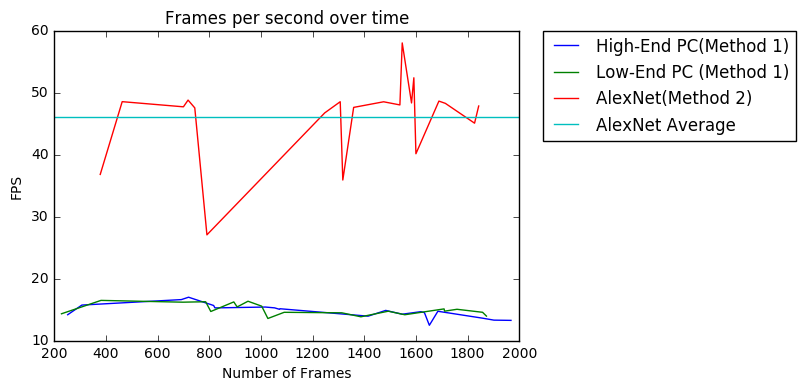

In [78]:
import matplotlib.pyplot as plt
import numpy as np

#the tuple lists from the two machines
#for (x,y), x=number of frames, y=FPS
#all values were obtained by runnig 20 iterations of the robotics test code for each of the lists below
high_end = [(1415, 13.9256576794853), (1633, 14.49185332237826), (692, 16.597510342312937), (1902, 13.28444212071557), (1968, 13.246013748166588), (817, 15.644747387887113), (1858, 13.601159544429823), (1547, 14.241132669300056), (720, 16.981532516090148), (1053, 15.264409145525736), (1074, 15.122074834207996), (1619, 14.649727644408387), (307, 15.714578203838439), (1017, 15.396027614268148), (1072, 15.03000395066713), (1685, 14.71474354165605), (1483, 14.854063609679645), (1652, 12.453919727322866), (822, 15.258390264332748), (252, 14.15650815690624)]
low_end = [(908, 15.416195359079301), (1387, 13.823327208123809), (806, 14.678643231174892), (1709, 15.096476461535536), (895, 16.222218979230302), (1873, 13.937914172324946), (1090, 14.54724361525289), (1493, 14.72498274726146), (381, 16.468721997640543), (1003, 15.538178186024538), (786, 16.25333398956898), (1858, 14.549253998647432), (698, 16.17969343116562), (1711, 14.733346877738205), (228, 14.310891946105043), (1313, 14.46601040546894), (1027, 13.550017874333518), (1557, 14.154111818030644), (1759, 15.03512430265126), (950, 16.33352216314256)]
deep_end = [(791, 27.04319265698128), (378, 36.78669900632446), (1317, 35.884312978810065), (1600, 40.121536054886185), (1475, 48.50281829310458), (1547, 57.99584848867834), (1592, 52.373840776552576), (1307, 48.513468898285545), (1247, 46.712585667958415), (1827, 45.05322939862442), (718, 48.77531176574092), (1359, 47.597558103594345), (1714, 48.247856842118544), (744, 47.51741021950383), (463, 48.52152919306825), (1689, 48.61284560394139), (700, 47.690765845874154), (1538, 47.99538578100847), (1843, 47.81908910801715), (1583, 48.31414759492721)]

#sorting the values to enable visualisation and comparison 
high_sr = sorted(high_end)
low_sr = sorted(low_end)
deep_sr = sorted(deep_end)

#seperating the frames and the FPS for each list
x_high = [x[0] for x in high_sr]
y_high = [x[1] for x in high_sr]

x_low = [x[0] for x in low_sr]
y_low = [x[1] for x in low_sr]

x_deep = [x[0] for x in deep_sr]
y_deep = [x[1] for x in deep_sr]

#average fps for alexnet
average = np.sum(y_deep)/len(y_deep)

#plotting the graph to visualise the lists
plt.plot(x_high,y_high,label='High-End PC(Method 1)')
plt.plot(x_low,y_low,label='Low-End PC (Method 1)')
plt.plot(x_deep,y_deep,label='AlexNet(Method 2)')
plt.plot((200, 2000), (average,average), label="AlexNet Average")
plt.xlabel('Number of Frames')
plt.ylabel('FPS')
plt.title('Frames per second over time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

This is a graph showing the error value of the predicted trajectory from VO, compared to the actual trajectory from the provided files, as the number of frames increase.

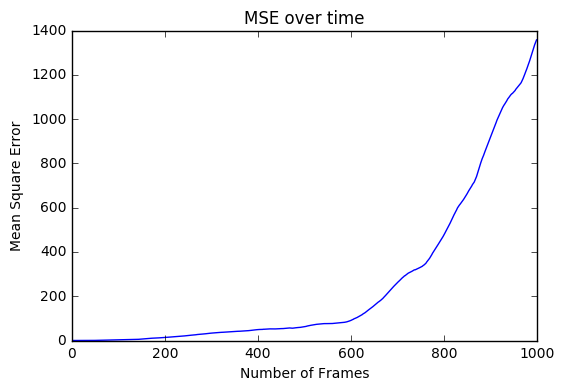

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#copying the lists from the VO method at the top
pred = np.copy(predicted)
act = np.copy(actual)

#MSE for all the frames
total_error=[]
for i in range(len(pred)): 
    total_error.append(mean_squared_error(pred[i],act[i]))
    
#plotting the graph to visualise the mean square error
plt.plot(total_error)
plt.xlabel('Number of Frames')
plt.ylabel('Mean Square Error')
plt.title('MSE over time')
plt.show()